<a href="https://colab.research.google.com/github/anshulk-cmu/GPU_2D-Heat-Diffusion-Equation/blob/main/2D_Heat_Diffusion_Equation_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install packages
!pip install -q cupy-cuda12x numpy matplotlib scikit-image scipy

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

# Verify installation
print("\n" + "="*70)
print("VERIFYING INSTALLATION")
print("="*70 + "\n")
print(f"NumPy: {np.__version__}")
print(f"CuPy: {cp.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

print("\n" + "="*70)
print("GPU COMPUTE INFRASTRUCTURE")
print("="*70 + "\n")

device = cp.cuda.Device(0)
props = cp.cuda.runtime.getDeviceProperties(device.id)

print(f"GPU Device Information:")
print(f"  Name: {props['name'].decode()}")
print(f"  Compute Capability: {device.compute_capability}")
print(f"  Total Memory: {props['totalGlobalMem'] / 1e9:.2f} GB")
print(f"  Multiprocessors: {props['multiProcessorCount']}")
print(f"  Max Threads per Block: {props['maxThreadsPerBlock']}")
print(f"  Max Threads per Multiprocessor: {props['maxThreadsPerMultiProcessor']}")
print(f"  Warp Size: {props['warpSize']}")
print(f"  Clock Rate: {props['clockRate'] / 1e6:.2f} GHz")
print(f"  Memory Clock Rate: {props['memoryClockRate'] / 1e6:.2f} GHz")
print(f"  Memory Bus Width: {props['memoryBusWidth']} bits")
print(f"  L2 Cache Size: {props['l2CacheSize'] / 1e6:.2f} MB")

# Memory info
mem_info = device.mem_info
print(f"\nMemory Status:")
print(f"  Free: {mem_info[0] / 1e9:.2f} GB")
print(f"  Total: {mem_info[1] / 1e9:.2f} GB")
print(f"  Used: {(mem_info[1] - mem_info[0]) / 1e9:.2f} GB")

# Test GPU computation
print("\n" + "="*70)
print("GPU COMPUTATION TEST")
print("="*70 + "\n")

x = cp.random.random((1000, 1000))
y = cp.random.random((1000, 1000))

# Warmup
_ = cp.dot(x, y)

# Timed test
import time
start = time.time()
result = cp.dot(x, y)
cp.cuda.Stream.null.synchronize()
elapsed = time.time() - start

print(f"Matrix multiplication (1000x1000): {elapsed*1000:.2f} ms")
print(f"Estimated GFLOPS: {(2 * 1000**3) / (elapsed * 1e9):.2f}")
print(f"GPU Test: PASSED")

print("\n" + "="*70)
print("ENVIRONMENT READY")
print("="*70 + "\n")


VERIFYING INSTALLATION

NumPy: 2.0.2
CuPy: 13.6.0
Matplotlib: 3.10.0

GPU COMPUTE INFRASTRUCTURE

GPU Device Information:
  Name: NVIDIA A100-SXM4-80GB
  Compute Capability: 80
  Total Memory: 85.17 GB
  Multiprocessors: 108
  Max Threads per Block: 1024
  Max Threads per Multiprocessor: 2048
  Warp Size: 32
  Clock Rate: 1.41 GHz
  Memory Clock Rate: 1.59 GHz
  Memory Bus Width: 5120 bits
  L2 Cache Size: 41.94 MB

Memory Status:
  Free: 84.67 GB
  Total: 85.17 GB
  Used: 0.50 GB

GPU COMPUTATION TEST

Matrix multiplication (1000x1000): 0.35 ms
Estimated GFLOPS: 5698.78
GPU Test: PASSED

ENVIRONMENT READY




                      2D HEAT DIFFUSION EQUATION                      

The 2D heat (diffusion) equation describes the distribution of heat (or 
temperature variation) in a given region over time. It is a parabolic 
partial differential equation (PDE).

GOVERNING PDE:
    ∂u/∂t = α(∂²u/∂x² + ∂²u/∂y²)

where:
    - u(x,y,t) : Temperature at position (x,y) and time t
    - α         : Thermal diffusivity coefficient [m²/s]
    - t         : Time variable
    - x, y      : Spatial coordinates

PHYSICAL INTERPRETATION:
    The equation states that the rate of temperature change at any point
    is proportional to the Laplacian (curvature) of the temperature field.
    Heat flows from regions of higher temperature to lower temperature.

PROBLEM SETUP:
    - Domain: Ω = [0, Lx] × [0, Ly]
    - Time: t ∈ [0, T_final]
    - Initial Condition: u(x,y,0) = u₀(x,y)
    - Boundary Conditions: Dirichlet (fixed temperature on boundaries)



                   FINITE DIFFERENCE DISCRETIZATION        

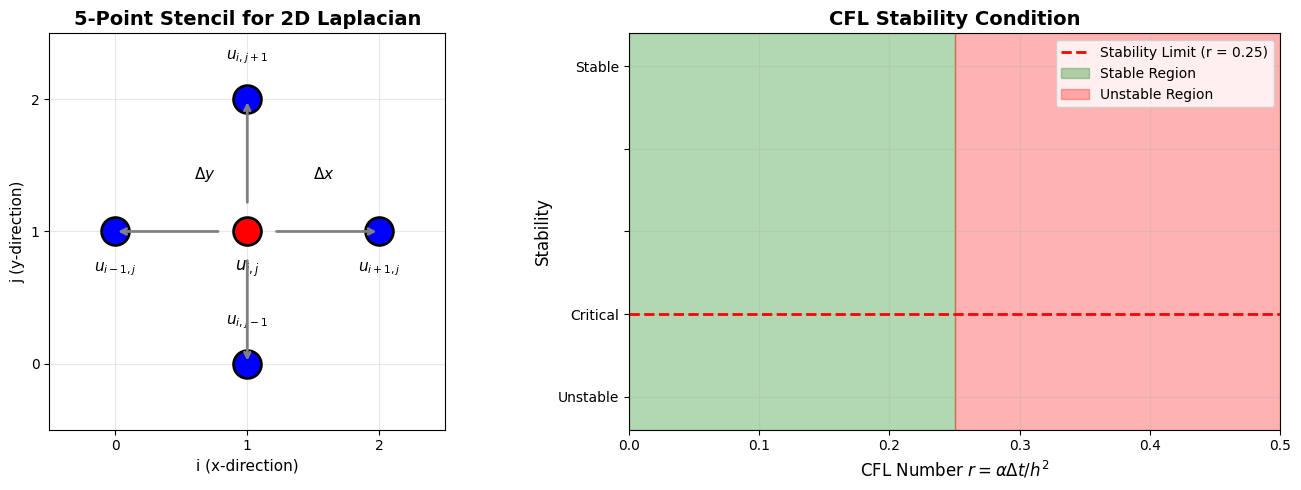


✓ Mathematical foundations documented
✓ Stencil visualization generated
✓ Stability analysis completed

PARAMETER CALCULATIONS FOR DIFFERENT GRID SIZES


256×256 Grid:
--------------------------------------------------
  Grid Size..................... 256 × 256
  Spatial Step (Δx)............. 0.003922 m
  Spatial Step (Δy)............. 0.003922 m
  Time Step (Δt)................ 3.075740e-04 s
  CFL Number (r)................ 0.20
  Thermal Diffusivity (α)....... 0.0100 m²/s
  Steps to t=0.1s............... 325

512×512 Grid:
--------------------------------------------------
  Grid Size..................... 512 × 512
  Spatial Step (Δx)............. 0.001957 m
  Spatial Step (Δy)............. 0.001957 m
  Time Step (Δt)................ 7.659284e-05 s
  CFL Number (r)................ 0.20
  Thermal Diffusivity (α)....... 0.0100 m²/s
  Steps to t=0.1s............... 1,305

1024×1024 Grid:
--------------------------------------------------
  Grid Size..................... 1024 × 1024
 

In [6]:
# ============================================================================
# MATHEMATICAL FOUNDATIONS: 2D HEAT DIFFUSION EQUATION
# ============================================================================

from IPython.display import display, Markdown, Latex
import textwrap

def print_section(title, content):
    """Helper function to display formatted sections"""
    print("\n" + "="*70)
    print(f"{title:^70}")
    print("="*70)
    print(content)
    print("="*70 + "\n")

# ============================================================================
# 1. GOVERNING EQUATION: 2D HEAT DIFFUSION
# ============================================================================

theory_1 = """
The 2D heat (diffusion) equation describes the distribution of heat (or
temperature variation) in a given region over time. It is a parabolic
partial differential equation (PDE).

GOVERNING PDE:
    ∂u/∂t = α(∂²u/∂x² + ∂²u/∂y²)

where:
    - u(x,y,t) : Temperature at position (x,y) and time t
    - α         : Thermal diffusivity coefficient [m²/s]
    - t         : Time variable
    - x, y      : Spatial coordinates

PHYSICAL INTERPRETATION:
    The equation states that the rate of temperature change at any point
    is proportional to the Laplacian (curvature) of the temperature field.
    Heat flows from regions of higher temperature to lower temperature.

PROBLEM SETUP:
    - Domain: Ω = [0, Lx] × [0, Ly]
    - Time: t ∈ [0, T_final]
    - Initial Condition: u(x,y,0) = u₀(x,y)
    - Boundary Conditions: Dirichlet (fixed temperature on boundaries)
"""

print_section("2D HEAT DIFFUSION EQUATION", theory_1)

# ============================================================================
# 2. FINITE DIFFERENCE DISCRETIZATION
# ============================================================================

theory_2 = """
SPATIAL DISCRETIZATION:
We discretize the spatial domain into a uniform grid:

    - Grid spacing: Δx = Lx/(Nx-1),  Δy = Ly/(Ny-1)
    - Grid points: x_i = i·Δx,  y_j = j·Δy
    - i = 0,1,...,Nx-1;  j = 0,1,...,Ny-1
    - Discrete solution: u_ij^n ≈ u(x_i, y_j, t_n)

TEMPORAL DISCRETIZATION:
    - Time step: Δt
    - Time levels: t_n = n·Δt,  n = 0,1,2,...

CENTRAL DIFFERENCE APPROXIMATION (2nd order accurate):

    ∂²u/∂x²|_{i,j} ≈ (u_{i+1,j} - 2u_{i,j} + u_{i-1,j})/Δx²

    ∂²u/∂y²|_{i,j} ≈ (u_{i,j+1} - 2u_{i,j} + u_{i,j-1})/Δy²

STENCIL REPRESENTATION (5-point stencil):

                u_{i,j+1}
                    |
    u_{i-1,j} -- u_{i,j} -- u_{i+1,j}
                    |
                u_{i,j-1}

EXPLICIT SCHEME (Forward Euler in Time):

    u_ij^{n+1} = u_ij^n + α·Δt·[(u_{i+1,j}^n - 2u_ij^n + u_{i-1,j}^n)/Δx²
                                + (u_{i,j+1}^n - 2u_ij^n + u_{i,j-1}^n)/Δy²]

IMPLICIT SCHEME (Backward Euler in Time):
Requires solving a linear system at each time step using iterative methods.
"""

print_section("FINITE DIFFERENCE DISCRETIZATION", theory_2)

# ============================================================================
# 3. JACOBI ITERATION METHOD
# ============================================================================

theory_3 = """
For implicit time integration, we need to solve a system of linear equations:
    A·u^{n+1} = b

where A is a sparse matrix and b contains known values from time t_n.

JACOBI ITERATIVE METHOD:
The Jacobi method is a classical iterative technique for solving linear systems.
It updates each grid point using values from the PREVIOUS iteration.

ALGORITHM:
    Initialize: u^{(0)} = initial guess

    For k = 0, 1, 2, ... until convergence:
        For each interior point (i,j):
            u_ij^{(k+1)} = (1/4)·[u_{i+1,j}^{(k)} + u_{i-1,j}^{(k)}
                                 + u_{i,j+1}^{(k)} + u_{i,j-1}^{(k)}]

    where (k) denotes the iteration number.

KEY PROPERTY - EMBARRASSINGLY PARALLEL:
    - Each grid point can be updated INDEPENDENTLY
    - Old values are read, new values written to separate array
    - Perfect for GPU parallelization (one thread per grid point)

CONVERGENCE CRITERION:
We check for convergence using the L2-norm of the residual:

    ||r^{(k)}||₂ = sqrt(Σ(u_ij^{(k+1)} - u_ij^{(k)})²)

    Converged when: ||r^{(k)}||₂ < tolerance (e.g., 10^-6)

CONVERGENCE RATE:
    Spectral radius: ρ = cos(π/N)  where N = max(Nx, Ny)

    As N → ∞, ρ → 1 (slower convergence for larger grids)
    Number of iterations ∝ O(N²)
"""

print_section("JACOBI ITERATION METHOD", theory_3)

# ============================================================================
# 4. STABILITY ANALYSIS (CFL CONDITION)
# ============================================================================

theory_4 = """
STABILITY CONDITION FOR EXPLICIT SCHEME:

The stability of the explicit finite difference scheme is governed by the
Courant-Friedrichs-Lewy (CFL) condition.

VON NEUMANN STABILITY ANALYSIS:
Substituting u_ij^n = ξ^n·e^{i(kx·x_i + ky·y_j)} into the difference equation
gives the amplification factor:

    ξ = 1 - 4α·Δt·[sin²(kx·Δx/2)/Δx² + sin²(ky·Δy/2)/Δy²]

STABILITY REQUIREMENT: |ξ| ≤ 1

For square grids (Δx = Δy = h):

    α·Δt/h² ≤ 1/4

This is the CFL stability condition!

CFL NUMBER (r):
    r = α·Δt/h²

    For stability: r ≤ 1/4 ≈ 0.25

PHYSICAL INTERPRETATION:
    - r measures how far information propagates in one time step
    - If Δt is too large, numerical instabilities arise (exponential growth)
    - Smaller Δx requires smaller Δt (more time steps needed)

PRACTICAL GUIDELINES:
    1. Choose spatial resolution: Δx, Δy
    2. Calculate maximum stable time step: Δt ≤ h²/(4α)
    3. Use safety factor: Δt = 0.2·h²/α (r = 0.2 < 0.25)

IMPLICIT SCHEMES:
    - Unconditionally stable (can use larger Δt)
    - But require solving linear systems (more work per step)
    - Trade-off: stability vs computational cost
"""

print_section("STABILITY ANALYSIS (CFL CONDITION)", theory_4)

# ============================================================================
# 5. NUMERICAL PARAMETERS SUMMARY
# ============================================================================

theory_5 = """
TYPICAL PROBLEM PARAMETERS:

Physical Domain:
    - Lx = Ly = 1.0 m
    - Thermal diffusivity: α = 0.01 m²/s (e.g., aluminum)

Discretization (for 512×512 grid):
    - Nx = Ny = 512
    - Δx = Δy = 1.0/511 ≈ 0.00196 m
    - h² = (0.00196)² ≈ 3.84×10⁻⁶ m²

Time Step (CFL stability):
    - r = 0.2 (safety factor)
    - Δt = 0.2·h²/α = 0.2·(3.84×10⁻⁶)/0.01 ≈ 7.68×10⁻⁵ s
    - For simulation to t=0.1s: ~1300 time steps needed

Convergence Tolerance:
    - Jacobi iterations: ε = 10⁻⁶
    - Maximum iterations per time step: 10,000

Boundary Conditions:
    - Left, Right, Top: T = 0°C (cold boundaries)
    - Bottom: T = 100°C (hot boundary)
    - OR: Initial hot spot in center, all boundaries at 0°C

Expected Behavior:
    - Heat diffuses from hot to cold regions
    - Eventually reaches steady state (∂u/∂t → 0)
    - Diffusion rate controlled by α
"""

print_section("NUMERICAL PARAMETERS", theory_5)

# ============================================================================
# 6. VISUALIZE THE STENCIL
# ============================================================================

print("\n" + "="*70)
print("VISUALIZATION: 5-POINT STENCIL")
print("="*70 + "\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stencil visualization
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-0.5, 2.5)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.set_title('5-Point Stencil for 2D Laplacian', fontsize=14, fontweight='bold')

# Draw grid points
points = {
    'center': (1, 1),
    'east': (2, 1),
    'west': (0, 1),
    'north': (1, 2),
    'south': (1, 0)
}

colors = {
    'center': 'red',
    'east': 'blue',
    'west': 'blue',
    'north': 'blue',
    'south': 'blue'
}

for name, (x, y) in points.items():
    ax1.plot(x, y, 'o', markersize=20, color=colors[name],
             markeredgecolor='black', markeredgewidth=2)
    if name == 'center':
        ax1.text(x, y-0.3, r'$u_{i,j}$', ha='center', fontsize=12, fontweight='bold')
    elif name == 'east':
        ax1.text(x, y-0.3, r'$u_{i+1,j}$', ha='center', fontsize=11)
    elif name == 'west':
        ax1.text(x, y-0.3, r'$u_{i-1,j}$', ha='center', fontsize=11)
    elif name == 'north':
        ax1.text(x, y+0.3, r'$u_{i,j+1}$', ha='center', fontsize=11)
    elif name == 'south':
        ax1.text(x, y+0.3, r'$u_{i,j-1}$', ha='center', fontsize=11)

# Draw arrows
ax1.annotate('', xy=(2, 1), xytext=(1.2, 1),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray'))
ax1.annotate('', xy=(0, 1), xytext=(0.8, 1),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray'))
ax1.annotate('', xy=(1, 2), xytext=(1, 1.2),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray'))
ax1.annotate('', xy=(1, 0), xytext=(1, 0.8),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray'))

ax1.text(1.5, 1.4, r'$\Delta x$', fontsize=11)
ax1.text(0.6, 1.4, r'$\Delta y$', fontsize=11)

ax1.set_xlabel('i (x-direction)', fontsize=11)
ax1.set_ylabel('j (y-direction)', fontsize=11)
ax1.set_xticks([0, 1, 2])
ax1.set_yticks([0, 1, 2])

# Stability region visualization
r_values = np.linspace(0, 0.5, 1000)
stable = r_values <= 0.25

ax2.axhline(y=0.25, color='red', linestyle='--', linewidth=2, label='Stability Limit (r = 0.25)')
ax2.axvspan(0, 0.25, alpha=0.3, color='green', label='Stable Region')
ax2.axvspan(0.25, 0.5, alpha=0.3, color='red', label='Unstable Region')
ax2.set_xlabel(r'CFL Number $r = \alpha \Delta t / h^2$', fontsize=12)
ax2.set_ylabel('Stability', fontsize=12)
ax2.set_title('CFL Stability Condition', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 0.5)
ax2.set_ylim(-0.1, 1.1)
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax2.set_yticklabels(['Unstable', 'Critical', '', '', 'Stable'])

plt.tight_layout()
plt.savefig('mathematical_foundations.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Mathematical foundations documented")
print("✓ Stencil visualization generated")
print("✓ Stability analysis completed")

# ============================================================================
# 7. PARAMETER CALCULATION HELPER
# ============================================================================

def calculate_parameters(Nx, Ny, Lx=1.0, Ly=1.0, alpha=0.01, r=0.2):
    """
    Calculate discretization parameters for given grid size

    Parameters:
    -----------
    Nx, Ny : Grid points in x and y directions
    Lx, Ly : Domain size in meters
    alpha  : Thermal diffusivity [m²/s]
    r      : CFL number (safety factor)

    Returns:
    --------
    Dictionary with all parameters
    """
    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)
    h = min(dx, dy)
    dt = r * h**2 / alpha

    params = {
        'Grid Size': f'{Nx} × {Ny}',
        'Spatial Step (Δx)': f'{dx:.6f} m',
        'Spatial Step (Δy)': f'{dy:.6f} m',
        'Time Step (Δt)': f'{dt:.6e} s',
        'CFL Number (r)': f'{r:.2f}',
        'Thermal Diffusivity (α)': f'{alpha:.4f} m²/s',
        'Steps to t=0.1s': f'{int(0.1/dt):,}'
    }

    return params

# Example calculations
print("\n" + "="*70)
print("PARAMETER CALCULATIONS FOR DIFFERENT GRID SIZES")
print("="*70 + "\n")

for grid_size in [256, 512, 1024, 2048]:
    print(f"\n{grid_size}×{grid_size} Grid:")
    print("-" * 50)
    params = calculate_parameters(grid_size, grid_size)
    for key, value in params.items():
        print(f"  {key:.<30} {value}")

print("\n" + "="*70)
print("THEORETICAL FOUNDATION: COMPLETE ✓")
print("="*70 + "\n")


GENERATING INITIAL CONDITIONS



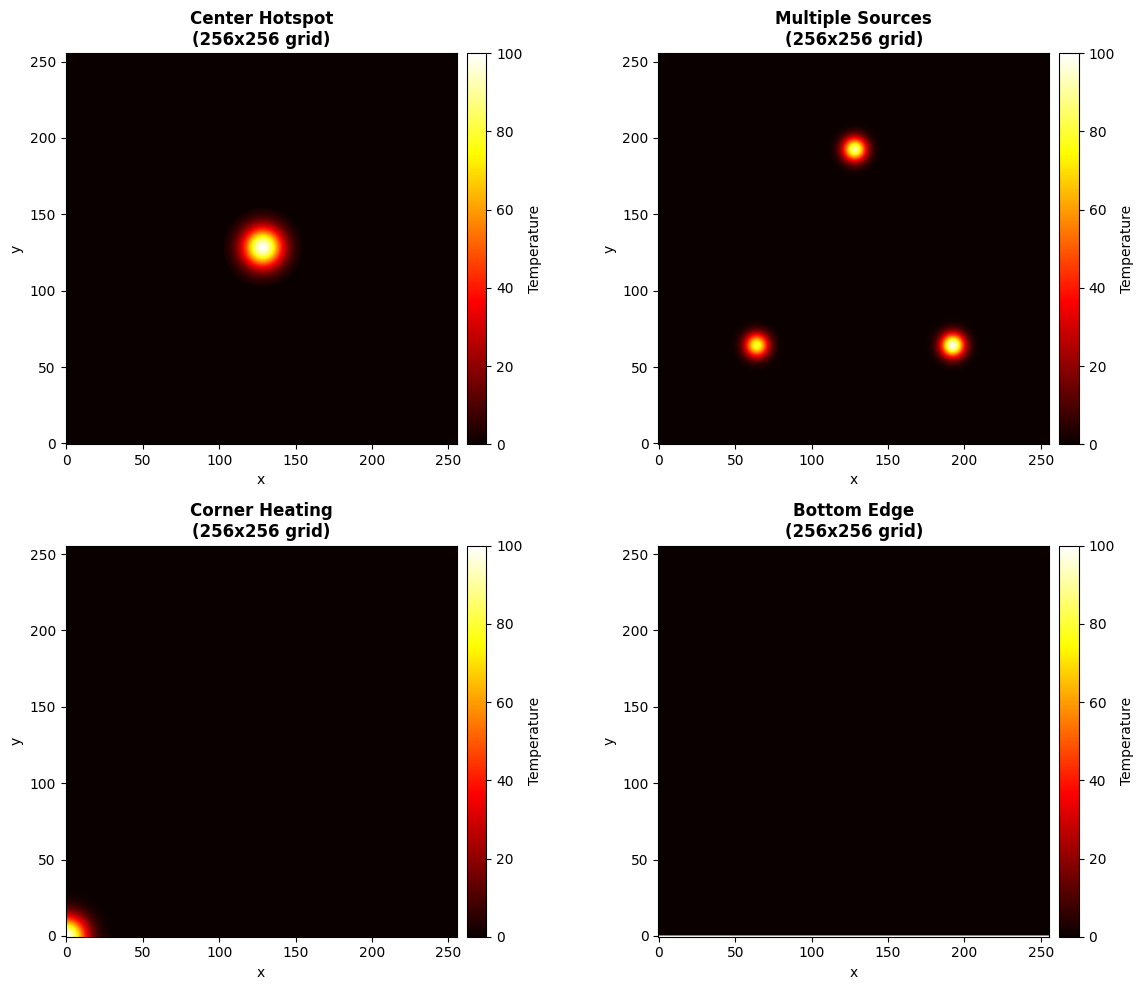

Initial conditions generated and visualized

RUNNING CPU BENCHMARKS


Benchmarking 256x256 grid...
  Explicit scheme (100 steps)... 0.0742 s
  Jacobi iterations (10 time steps)... 6.9930 s (10000 iterations)
  Visualizing evolution...


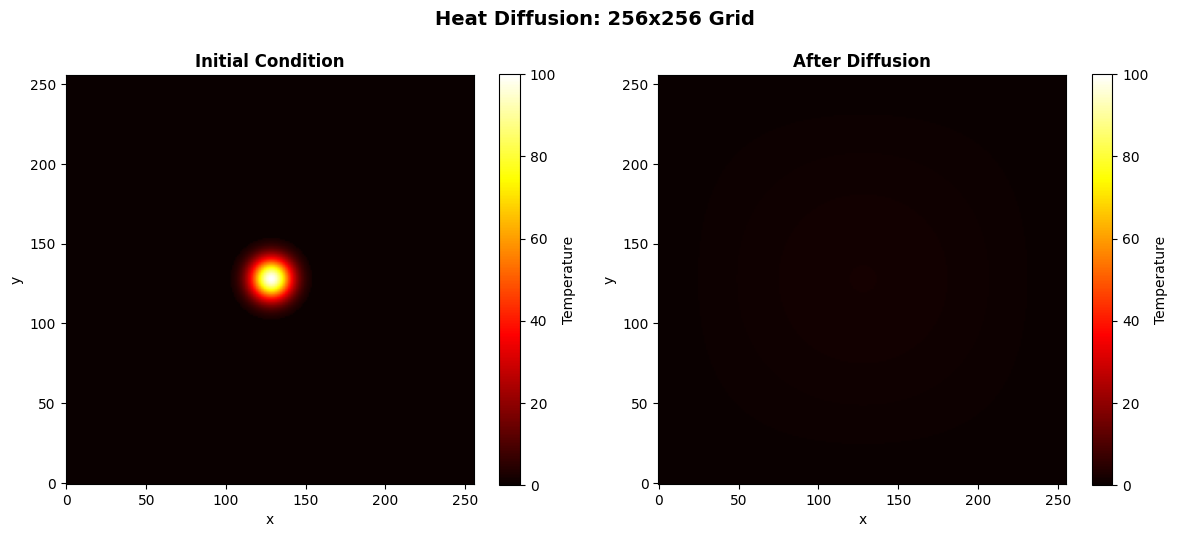


Benchmarking 512x512 grid...
  Explicit scheme (100 steps)... 0.3062 s
  Jacobi iterations (10 time steps)... 20.4723 s (10000 iterations)

Benchmarking 1024x1024 grid...
  Explicit scheme (100 steps)... 1.9353 s
  Jacobi iterations (10 time steps)... 97.7565 s (10000 iterations)

CPU BASELINE BENCHMARK RESULTS


256x256 Grid:
----------------------------------------------------------------------
  Explicit Scheme.........................     0.0742 s
  Jacobi Method...........................     6.9930 s  (10000 iterations)

512x512 Grid:
----------------------------------------------------------------------
  Explicit Scheme.........................     0.3062 s
  Jacobi Method...........................    20.4723 s  (10000 iterations)

1024x1024 Grid:
----------------------------------------------------------------------
  Explicit Scheme.........................     1.9353 s
  Jacobi Method...........................    97.7565 s  (10000 iterations)




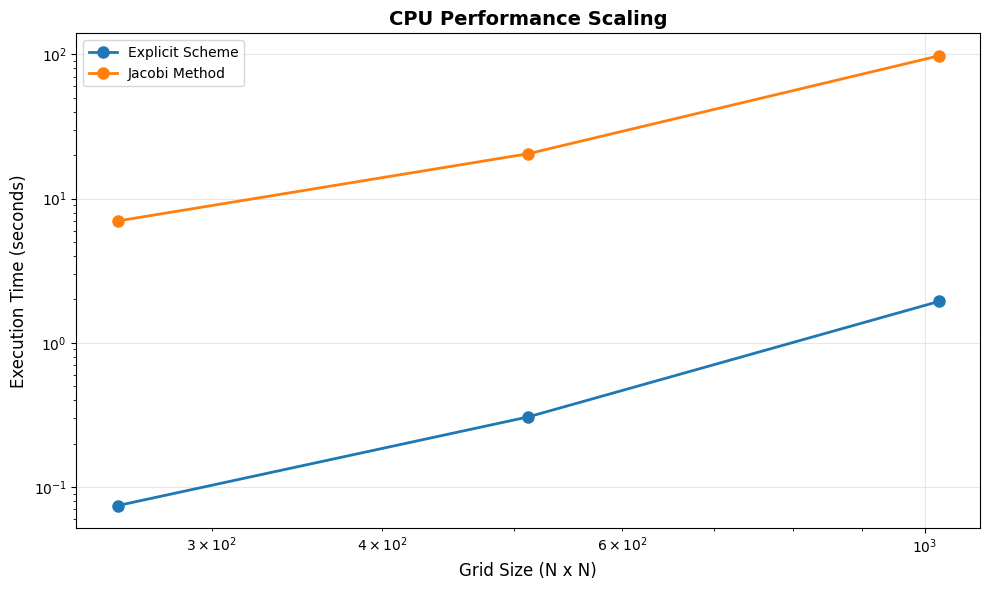


CPU BASELINE: COMPLETE



In [7]:
# ============================================================================
# CPU BASELINE IMPLEMENTATION & DATASET GENERATION
# ============================================================================

import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ============================================================================
# DATASET GENERATION FUNCTIONS
# ============================================================================

class InitialConditions:
    """Generate different initial temperature distributions"""

    @staticmethod
    def center_hotspot(Nx, Ny, T_hot=100.0, radius=0.1):
        """Single hot spot at center"""
        u = np.zeros((Ny, Nx), dtype=np.float64)
        center_x, center_y = Nx // 2, Ny // 2

        for j in range(Ny):
            for i in range(Nx):
                dist = np.sqrt((i - center_x)**2 + (j - center_y)**2)
                if dist < radius * min(Nx, Ny):
                    u[j, i] = T_hot * np.exp(-dist**2 / (0.05 * min(Nx, Ny))**2)

        return u

    @staticmethod
    def multiple_sources(Nx, Ny, T_hot=100.0):
        """Multiple heat sources at different locations"""
        u = np.zeros((Ny, Nx), dtype=np.float64)

        sources = [
            (Nx // 4, Ny // 4, T_hot * 0.8),
            (3 * Nx // 4, Ny // 4, T_hot * 1.0),
            (Nx // 2, 3 * Ny // 4, T_hot * 0.9),
        ]

        for cx, cy, temp in sources:
            for j in range(Ny):
                for i in range(Nx):
                    dist = np.sqrt((i - cx)**2 + (j - cy)**2)
                    u[j, i] += temp * np.exp(-dist**2 / (0.03 * min(Nx, Ny))**2)

        return u

    @staticmethod
    def corner_heating(Nx, Ny, T_hot=100.0):
        """Heat concentrated in corner"""
        u = np.zeros((Ny, Nx), dtype=np.float64)

        for j in range(Ny):
            for i in range(Nx):
                dist = np.sqrt(i**2 + j**2)
                u[j, i] = T_hot * np.exp(-dist**2 / (0.05 * min(Nx, Ny))**2)

        return u

    @staticmethod
    def bottom_edge_heating(Nx, Ny, T_hot=100.0):
        """Hot bottom edge, cold elsewhere"""
        u = np.zeros((Ny, Nx), dtype=np.float64)
        u[0, :] = T_hot
        return u

# ============================================================================
# CPU JACOBI SOLVER
# ============================================================================

class CPUJacobiSolver:
    """CPU-based Jacobi iterative solver for 2D heat equation"""

    def __init__(self, Nx, Ny, alpha=0.01, Lx=1.0, Ly=1.0):
        self.Nx = Nx
        self.Ny = Ny
        self.alpha = alpha
        self.Lx = Lx
        self.Ly = Ly

        self.dx = Lx / (Nx - 1)
        self.dy = Ly / (Ny - 1)
        self.h = min(self.dx, self.dy)

        r = 0.2
        self.dt = r * self.h**2 / self.alpha

        self.rx = alpha * self.dt / (self.dx**2)
        self.ry = alpha * self.dt / (self.dy**2)

    def explicit_step(self, u):
        """Single explicit time step using vectorized operations"""
        u_new = u.copy()

        u_new[1:-1, 1:-1] = u[1:-1, 1:-1] + \
                            self.rx * (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]) + \
                            self.ry * (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1])

        return u_new

    def jacobi_iteration(self, u, max_iter=1000, tol=1e-6):
        """Jacobi iterative solver for implicit scheme"""
        u_old = u.copy()
        u_new = u.copy()

        for iteration in range(max_iter):
            u_new[1:-1, 1:-1] = 0.25 * (u_old[1:-1, 2:] + u_old[1:-1, :-2] +
                                         u_old[2:, 1:-1] + u_old[:-2, 1:-1])

            diff = np.linalg.norm(u_new - u_old)

            if diff < tol:
                return u_new, iteration + 1

            u_old = u_new.copy()

        return u_new, max_iter

    def solve_explicit(self, u_init, num_steps=100):
        """Solve using explicit scheme"""
        u = u_init.copy()

        start_time = time.time()

        for step in range(num_steps):
            u = self.explicit_step(u)

        elapsed_time = time.time() - start_time

        return u, elapsed_time

    def solve_jacobi(self, u_init, num_time_steps=10, max_iter=1000, tol=1e-6):
        """Solve using implicit scheme with Jacobi iterations"""
        u = u_init.copy()
        total_iterations = 0

        start_time = time.time()

        for step in range(num_time_steps):
            u, iters = self.jacobi_iteration(u, max_iter, tol)
            total_iterations += iters

        elapsed_time = time.time() - start_time

        return u, elapsed_time, total_iterations

# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_initial_conditions(grid_sizes=[256]):
    """Display all initial condition types"""

    conditions = {
        'Center Hotspot': InitialConditions.center_hotspot,
        'Multiple Sources': InitialConditions.multiple_sources,
        'Corner Heating': InitialConditions.corner_heating,
        'Bottom Edge': InitialConditions.bottom_edge_heating
    }

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    N = grid_sizes[0]

    for idx, (name, func) in enumerate(conditions.items()):
        u = func(N, N)

        im = axes[idx].imshow(u, cmap='hot', origin='lower', interpolation='bilinear')
        axes[idx].set_title(f'{name}\n({N}x{N} grid)', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('x')
        axes[idx].set_ylabel('y')

        divider = make_axes_locatable(axes[idx])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax, label='Temperature')

    plt.tight_layout()
    plt.savefig('initial_conditions.png', dpi=150, bbox_inches='tight')
    plt.show()

def visualize_evolution(u_init, u_final, title="Temperature Evolution"):
    """Show initial and final states side by side"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    vmin = min(u_init.min(), u_final.min())
    vmax = max(u_init.max(), u_final.max())

    im1 = ax1.imshow(u_init, cmap='hot', origin='lower', vmin=vmin, vmax=vmax)
    ax1.set_title('Initial Condition', fontsize=12, fontweight='bold')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    plt.colorbar(im1, ax=ax1, label='Temperature')

    im2 = ax2.imshow(u_final, cmap='hot', origin='lower', vmin=vmin, vmax=vmax)
    ax2.set_title('After Diffusion', fontsize=12, fontweight='bold')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.colorbar(im2, ax=ax2, label='Temperature')

    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# ============================================================================
# BENCHMARKING
# ============================================================================

class BenchmarkResults:
    """Store and display benchmark results"""

    def __init__(self):
        self.results = []

    def add_result(self, grid_size, method, time_elapsed, iterations=None):
        self.results.append({
            'grid_size': grid_size,
            'method': method,
            'time': time_elapsed,
            'iterations': iterations
        })

    def display(self):
        print("\n" + "="*70)
        print("CPU BASELINE BENCHMARK RESULTS")
        print("="*70 + "\n")

        grid_sizes = sorted(set([r['grid_size'] for r in self.results]))

        for N in grid_sizes:
            print(f"\n{N}x{N} Grid:")
            print("-" * 70)

            for result in self.results:
                if result['grid_size'] == N:
                    method = result['method']
                    time_val = result['time']
                    iters = result['iterations']

                    print(f"  {method:.<40} {time_val:>10.4f} s", end="")
                    if iters is not None:
                        print(f"  ({iters} iterations)")
                    else:
                        print()

        print("\n" + "="*70 + "\n")

    def plot_scaling(self):
        """Plot performance scaling"""

        grid_sizes = sorted(set([r['grid_size'] for r in self.results]))
        methods = sorted(set([r['method'] for r in self.results]))

        fig, ax = plt.subplots(figsize=(10, 6))

        for method in methods:
            times = []
            sizes = []

            for N in grid_sizes:
                for result in self.results:
                    if result['grid_size'] == N and result['method'] == method:
                        times.append(result['time'])
                        sizes.append(N)

            ax.plot(sizes, times, marker='o', linewidth=2, markersize=8, label=method)

        ax.set_xlabel('Grid Size (N x N)', fontsize=12)
        ax.set_ylabel('Execution Time (seconds)', fontsize=12)
        ax.set_title('CPU Performance Scaling', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        ax.set_xscale('log')
        ax.set_yscale('log')

        plt.tight_layout()
        plt.savefig('cpu_scaling.png', dpi=150, bbox_inches='tight')
        plt.show()

# ============================================================================
# RUN BENCHMARKS
# ============================================================================

def run_comprehensive_benchmark():
    """Execute full CPU benchmark suite"""

    print("\n" + "="*70)
    print("GENERATING INITIAL CONDITIONS")
    print("="*70 + "\n")

    visualize_initial_conditions([256])

    print("Initial conditions generated and visualized")

    print("\n" + "="*70)
    print("RUNNING CPU BENCHMARKS")
    print("="*70 + "\n")

    grid_sizes = [256, 512, 1024]
    benchmark = BenchmarkResults()

    for N in grid_sizes:
        print(f"\nBenchmarking {N}x{N} grid...")

        u_init = InitialConditions.center_hotspot(N, N)
        solver = CPUJacobiSolver(N, N)

        print(f"  Explicit scheme (100 steps)...", end=" ")
        u_final, time_explicit = solver.solve_explicit(u_init, num_steps=100)
        benchmark.add_result(N, 'Explicit Scheme', time_explicit)
        print(f"{time_explicit:.4f} s")

        print(f"  Jacobi iterations (10 time steps)...", end=" ")
        u_final, time_jacobi, iters = solver.solve_jacobi(u_init, num_time_steps=10, max_iter=1000)
        benchmark.add_result(N, 'Jacobi Method', time_jacobi, iters)
        print(f"{time_jacobi:.4f} s ({iters} iterations)")

        if N == 256:
            print(f"  Visualizing evolution...")
            visualize_evolution(u_init, u_final, f"Heat Diffusion: {N}x{N} Grid")

    benchmark.display()
    benchmark.plot_scaling()

    print("\n" + "="*70)
    print("CPU BASELINE: COMPLETE")
    print("="*70 + "\n")

    return benchmark

benchmark_results = run_comprehensive_benchmark()


COMPILING CUDA KERNELS

Compiling basic kernels...
Compiling shared memory kernels...
Kernel compilation complete

RUNNING GPU BENCHMARKS


Benchmarking 256x256 grid...
  Basic explicit kernel (100 steps)... 0.077208 s [0.96x speedup]
  Shared memory explicit kernel (100 steps)... 0.086978 s [0.85x speedup]
  Basic Jacobi kernel (10 time steps)... 3.368446 s [2.08x speedup] (10000 iterations)
  Shared memory Jacobi kernel (10 time steps)... 3.398900 s [2.06x speedup] (10000 iterations)

Benchmarking 512x512 grid...
  Basic explicit kernel (100 steps)... 0.039008 s [7.85x speedup]
  Shared memory explicit kernel (100 steps)... 0.038802 s [7.89x speedup]
  Basic Jacobi kernel (10 time steps)... 3.675546 s [5.57x speedup] (10000 iterations)
  Shared memory Jacobi kernel (10 time steps)... 3.641272 s [5.62x speedup] (10000 iterations)

Benchmarking 1024x1024 grid...
  Basic explicit kernel (100 steps)... 0.038213 s [50.64x speedup]
  Shared memory explicit kernel (100 steps)... 0.037896 s

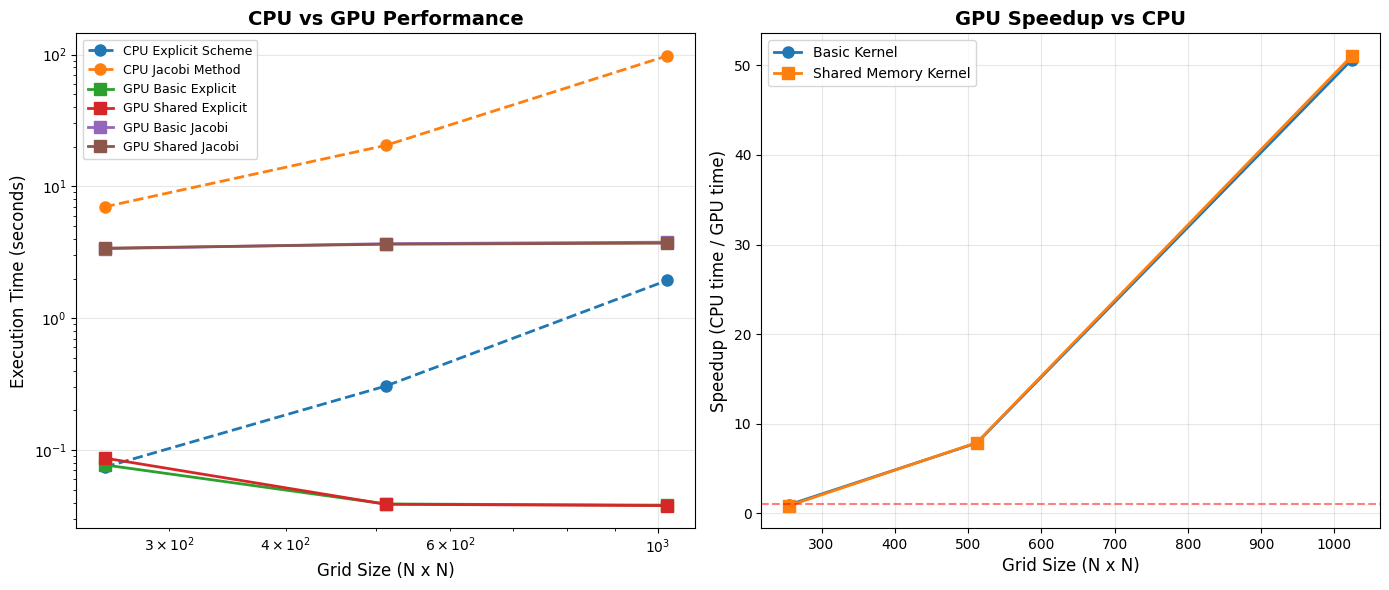


GPU BENCHMARKS: COMPLETE



In [11]:
# ============================================================================
# CUDA KERNEL IMPLEMENTATION
# ============================================================================

import cupy as cp
from cupy import cuda
import time

# ============================================================================
# KERNEL 1: BASIC GLOBAL MEMORY IMPLEMENTATION
# ============================================================================

basic_kernel_code = r'''
extern "C" __global__
void heat_diffusion_basic(const double* u_old, double* u_new,
                          int Nx, int Ny, double rx, double ry) {

    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i > 0 && i < Nx - 1 && j > 0 && j < Ny - 1) {
        int idx = j * Nx + i;
        int idx_left = j * Nx + (i - 1);
        int idx_right = j * Nx + (i + 1);
        int idx_down = (j - 1) * Nx + i;
        int idx_up = (j + 1) * Nx + i;

        u_new[idx] = u_old[idx] +
                     rx * (u_old[idx_right] - 2.0 * u_old[idx] + u_old[idx_left]) +
                     ry * (u_old[idx_up] - 2.0 * u_old[idx] + u_old[idx_down]);
    }
}
'''

basic_jacobi_kernel_code = r'''
extern "C" __global__
void jacobi_iteration_basic(const double* u_old, double* u_new, int Nx, int Ny) {

    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i > 0 && i < Nx - 1 && j > 0 && j < Ny - 1) {
        int idx = j * Nx + i;
        int idx_left = j * Nx + (i - 1);
        int idx_right = j * Nx + (i + 1);
        int idx_down = (j - 1) * Nx + i;
        int idx_up = (j + 1) * Nx + i;

        u_new[idx] = 0.25 * (u_old[idx_left] + u_old[idx_right] +
                             u_old[idx_down] + u_old[idx_up]);
    }
}
'''

# ============================================================================
# KERNEL 2: SHARED MEMORY OPTIMIZED IMPLEMENTATION
# ============================================================================

shared_kernel_code = r'''
extern "C" __global__
void heat_diffusion_shared(const double* u_old, double* u_new,
                           int Nx, int Ny, double rx, double ry) {

    __shared__ double s_data[18][18];

    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    int tx = threadIdx.x + 1;
    int ty = threadIdx.y + 1;

    if (i < Nx && j < Ny) {
        s_data[ty][tx] = u_old[j * Nx + i];

        if (threadIdx.x == 0 && i > 0) {
            s_data[ty][0] = u_old[j * Nx + (i - 1)];
        }
        if (threadIdx.x == blockDim.x - 1 && i < Nx - 1) {
            s_data[ty][tx + 1] = u_old[j * Nx + (i + 1)];
        }
        if (threadIdx.y == 0 && j > 0) {
            s_data[0][tx] = u_old[(j - 1) * Nx + i];
        }
        if (threadIdx.y == blockDim.y - 1 && j < Ny - 1) {
            s_data[ty + 1][tx] = u_old[(j + 1) * Nx + i];
        }
    }

    __syncthreads();

    if (i > 0 && i < Nx - 1 && j > 0 && j < Ny - 1) {
        int idx = j * Nx + i;

        u_new[idx] = s_data[ty][tx] +
                     rx * (s_data[ty][tx + 1] - 2.0 * s_data[ty][tx] + s_data[ty][tx - 1]) +
                     ry * (s_data[ty + 1][tx] - 2.0 * s_data[ty][tx] + s_data[ty - 1][tx]);
    }
}
'''

shared_jacobi_kernel_code = r'''
extern "C" __global__
void jacobi_iteration_shared(const double* u_old, double* u_new, int Nx, int Ny) {

    __shared__ double s_data[18][18];

    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    int tx = threadIdx.x + 1;
    int ty = threadIdx.y + 1;

    if (i < Nx && j < Ny) {
        s_data[ty][tx] = u_old[j * Nx + i];

        if (threadIdx.x == 0 && i > 0) {
            s_data[ty][0] = u_old[j * Nx + (i - 1)];
        }
        if (threadIdx.x == blockDim.x - 1 && i < Nx - 1) {
            s_data[ty][tx + 1] = u_old[j * Nx + (i + 1)];
        }
        if (threadIdx.y == 0 && j > 0) {
            s_data[0][tx] = u_old[(j - 1) * Nx + i];
        }
        if (threadIdx.y == blockDim.y - 1 && j < Ny - 1) {
            s_data[ty + 1][tx] = u_old[(j + 1) * Nx + i];
        }
    }

    __syncthreads();

    if (i > 0 && i < Nx - 1 && j > 0 && j < Ny - 1) {
        int idx = j * Nx + i;

        u_new[idx] = 0.25 * (s_data[ty][tx - 1] + s_data[ty][tx + 1] +
                             s_data[ty - 1][tx] + s_data[ty + 1][tx]);
    }
}
'''

# ============================================================================
# GPU SOLVER CLASS
# ============================================================================

class GPUSolver:
    """GPU-based solver with basic and optimized kernels"""

    def __init__(self, Nx, Ny, alpha=0.01, Lx=1.0, Ly=1.0):
        self.Nx = Nx
        self.Ny = Ny
        self.alpha = alpha

        self.dx = Lx / (Nx - 1)
        self.dy = Ly / (Ny - 1)
        self.h = min(self.dx, self.dy)

        r = 0.2
        self.dt = r * self.h**2 / self.alpha

        self.rx = alpha * self.dt / (self.dx**2)
        self.ry = alpha * self.dt / (self.dy**2)

        self.basic_explicit = cp.RawKernel(basic_kernel_code, 'heat_diffusion_basic')
        self.basic_jacobi = cp.RawKernel(basic_jacobi_kernel_code, 'jacobi_iteration_basic')
        self.shared_explicit = cp.RawKernel(shared_kernel_code, 'heat_diffusion_shared')
        self.shared_jacobi = cp.RawKernel(shared_jacobi_kernel_code, 'jacobi_iteration_shared')

        self.block_size = (16, 16)
        self.grid_size = (
            (Nx + self.block_size[0] - 1) // self.block_size[0],
            (Ny + self.block_size[1] - 1) // self.block_size[1]
        )

    def solve_explicit_basic(self, u_init, num_steps=100):
        """Explicit scheme with basic kernel"""
        u_old = cp.asarray(u_init, dtype=cp.float64)
        u_new = cp.zeros_like(u_old)

        # Convert numpy slices to cupy arrays before assignment
        u_old[:, 0] = cp.asarray(u_init[:, 0])
        u_old[:, -1] = cp.asarray(u_init[:, -1])
        u_old[0, :] = cp.asarray(u_init[0, :])
        u_old[-1, :] = cp.asarray(u_init[-1, :])

        cp.cuda.Stream.null.synchronize()
        start = time.time()

        for step in range(num_steps):
            self.basic_explicit(
                self.grid_size, self.block_size,
                (u_old, u_new, self.Nx, self.Ny, self.rx, self.ry)
            )

            # Convert numpy slices to cupy arrays before assignment
            u_new[:, 0] = cp.asarray(u_init[:, 0])
            u_new[:, -1] = cp.asarray(u_init[:, -1])
            u_new[0, :] = cp.asarray(u_init[0, :])
            u_new[-1, :] = cp.asarray(u_init[-1, :])

            u_old, u_new = u_new, u_old

        cp.cuda.Stream.null.synchronize()
        elapsed = time.time() - start

        return cp.asnumpy(u_old), elapsed

    def solve_explicit_shared(self, u_init, num_steps=100):
        """Explicit scheme with shared memory kernel"""
        u_old = cp.asarray(u_init, dtype=cp.float64)
        u_new = cp.zeros_like(u_old)

        # Convert numpy slices to cupy arrays before assignment
        u_old[:, 0] = cp.asarray(u_init[:, 0])
        u_old[:, -1] = cp.asarray(u_init[:, -1])
        u_old[0, :] = cp.asarray(u_init[0, :])
        u_old[-1, :] = cp.asarray(u_init[-1, :])

        cp.cuda.Stream.null.synchronize()
        start = time.time()

        for step in range(num_steps):
            self.shared_explicit(
                self.grid_size, self.block_size,
                (u_old, u_new, self.Nx, self.Ny, self.rx, self.ry)
            )

            # Convert numpy slices to cupy arrays before assignment
            u_new[:, 0] = cp.asarray(u_init[:, 0])
            u_new[:, -1] = cp.asarray(u_init[:, -1])
            u_new[0, :] = cp.asarray(u_init[0, :])
            u_new[-1, :] = cp.asarray(u_init[-1, :])

            u_old, u_new = u_new, u_old

        cp.cuda.Stream.null.synchronize()
        elapsed = time.time() - start

        return cp.asnumpy(u_old), elapsed

    def solve_jacobi_basic(self, u_init, num_time_steps=10, max_iter=1000):
        """Jacobi iteration with basic kernel"""
        u_old = cp.asarray(u_init, dtype=cp.float64)
        u_new = cp.zeros_like(u_old)

        total_iterations = 0

        cp.cuda.Stream.null.synchronize()
        start = time.time()

        for t_step in range(num_time_steps):
            for iteration in range(max_iter):
                self.basic_jacobi(
                    self.grid_size, self.block_size,
                    (u_old, u_new, self.Nx, self.Ny)
                )

                # Convert numpy slices to cupy arrays before assignment
                u_new[:, 0] = cp.asarray(u_init[:, 0])
                u_new[:, -1] = cp.asarray(u_init[:, -1])
                u_new[0, :] = cp.asarray(u_init[0, :])
                u_new[-1, :] = cp.asarray(u_init[-1, :])

                u_old, u_new = u_new, u_old
                total_iterations += 1

        cp.cuda.Stream.null.synchronize()
        elapsed = time.time() - start

        return cp.asnumpy(u_old), elapsed, total_iterations

    def solve_jacobi_shared(self, u_init, num_time_steps=10, max_iter=1000):
        """Jacobi iteration with shared memory kernel"""
        u_old = cp.asarray(u_init, dtype=cp.float64)
        u_new = cp.zeros_like(u_old)

        total_iterations = 0

        cp.cuda.Stream.null.synchronize()
        start = time.time()

        for t_step in range(num_time_steps):
            for iteration in range(max_iter):
                self.shared_jacobi(
                    self.grid_size, self.block_size,
                    (u_old, u_new, self.Nx, self.Ny)
                )

                # Convert numpy slices to cupy arrays before assignment
                u_new[:, 0] = cp.asarray(u_init[:, 0])
                u_new[:, -1] = cp.asarray(u_init[:, -1])
                u_new[0, :] = cp.asarray(u_init[0, :])
                u_new[-1, :] = cp.asarray(u_init[-1, :])

                u_old, u_new = u_new, u_old
                total_iterations += 1

        cp.cuda.Stream.null.synchronize()
        elapsed = time.time() - start

        return cp.asnumpy(u_old), elapsed, total_iterations

# ============================================================================
# GPU BENCHMARK
# ============================================================================

class GPUBenchmark:
    """Comprehensive GPU benchmark suite"""

    def __init__(self):
        self.results = []

    def add_result(self, grid_size, method, time_elapsed, speedup=None, iterations=None):
        self.results.append({
            'grid_size': grid_size,
            'method': method,
            'time': time_elapsed,
            'speedup': speedup,
            'iterations': iterations
        })

    def display(self):
        print("\n" + "="*70)
        print("GPU BENCHMARK RESULTS")
        print("="*70 + "\n")

        grid_sizes = sorted(set([r['grid_size'] for r in self.results]))

        for N in grid_sizes:
            print(f"\n{N}x{N} Grid:")
            print("-" * 70)

            for result in self.results:
                if result['grid_size'] == N:
                    method = result['method']
                    time_val = result['time']
                    speedup = result['speedup']
                    iters = result['iterations']

                    print(f"  {method:.<40} {time_val:>10.6f} s", end="")
                    if speedup is not None:
                        print(f"  [{speedup:>6.2f}x speedup]", end="")
                    if iters is not None:
                        print(f"  ({iters} iterations)", end="")
                    print()

        print("\n" + "="*70 + "\n")

    def plot_comparison(self, cpu_results):
        """Compare GPU vs CPU performance"""

        grid_sizes = sorted(set([r['grid_size'] for r in self.results]))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        methods_gpu = ['Basic Explicit', 'Shared Explicit', 'Basic Jacobi', 'Shared Jacobi']
        methods_cpu = ['Explicit Scheme', 'Jacobi Method']

        for method in methods_cpu:
            times = []
            sizes = []
            for N in grid_sizes:
                for result in cpu_results.results:
                    if result['grid_size'] == N and result['method'] == method:
                        times.append(result['time'])
                        sizes.append(N)
            if times:
                ax1.plot(sizes, times, marker='o', linewidth=2, markersize=8,
                        label=f'CPU {method}', linestyle='--')

        for method in methods_gpu:
            times = []
            sizes = []
            for N in grid_sizes:
                for result in self.results:
                    if result['grid_size'] == N and result['method'] == method:
                        times.append(result['time'])
                        sizes.append(N)
            if times:
                ax1.plot(sizes, times, marker='s', linewidth=2, markersize=8,
                        label=f'GPU {method}')

        ax1.set_xlabel('Grid Size (N x N)', fontsize=12)
        ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
        ax1.set_title('CPU vs GPU Performance', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend(fontsize=9)
        ax1.set_xscale('log')
        ax1.set_yscale('log')

        speedups_basic = []
        speedups_shared = []
        sizes_speedup = []

        for N in grid_sizes:
            cpu_time = None
            gpu_basic = None
            gpu_shared = None

            for result in cpu_results.results:
                if result['grid_size'] == N and result['method'] == 'Explicit Scheme':
                    cpu_time = result['time']

            for result in self.results:
                if result['grid_size'] == N:
                    if result['method'] == 'Basic Explicit':
                        gpu_basic = result['time']
                    elif result['method'] == 'Shared Explicit':
                        gpu_shared = result['time']

            if cpu_time and gpu_basic and gpu_shared:
                speedups_basic.append(cpu_time / gpu_basic)
                speedups_shared.append(cpu_time / gpu_shared)
                sizes_speedup.append(N)

        ax2.plot(sizes_speedup, speedups_basic, marker='o', linewidth=2,
                markersize=8, label='Basic Kernel')
        ax2.plot(sizes_speedup, speedups_shared, marker='s', linewidth=2,
                markersize=8, label='Shared Memory Kernel')

        ax2.set_xlabel('Grid Size (N x N)', fontsize=12)
        ax2.set_ylabel('Speedup (CPU time / GPU time)', fontsize=12)
        ax2.set_title('GPU Speedup vs CPU', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend(fontsize=10)
        ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No speedup')

        plt.tight_layout()
        plt.savefig('gpu_performance.png', dpi=150, bbox_inches='tight')
        plt.show()

# ============================================================================
# RUN GPU BENCHMARKS
# ============================================================================

def run_gpu_benchmark(cpu_results):
    """Execute comprehensive GPU benchmark"""

    print("\n" + "="*70)
    print("COMPILING CUDA KERNELS")
    print("="*70 + "\n")

    print("Compiling basic kernels...")
    test_solver = GPUSolver(64, 64)
    print("Compiling shared memory kernels...")
    print("Kernel compilation complete")

    print("\n" + "="*70)
    print("RUNNING GPU BENCHMARKS")
    print("="*70 + "\n")

    grid_sizes = [256, 512, 1024]
    gpu_benchmark = GPUBenchmark()

    for N in grid_sizes:
        print(f"\nBenchmarking {N}x{N} grid...")

        u_init = InitialConditions.center_hotspot(N, N)
        solver = GPUSolver(N, N)

        cpu_time_explicit = None
        for result in cpu_results.results:
            if result['grid_size'] == N and result['method'] == 'Explicit Scheme':
                cpu_time_explicit = result['time']

        print(f"  Basic explicit kernel (100 steps)...", end=" ")
        u_final, time_basic = solver.solve_explicit_basic(u_init, num_steps=100)
        speedup_basic = cpu_time_explicit / time_basic if cpu_time_explicit else None
        gpu_benchmark.add_result(N, 'Basic Explicit', time_basic, speedup_basic)
        print(f"{time_basic:.6f} s", end="")
        if speedup_basic:
            print(f" [{speedup_basic:.2f}x speedup]")
        else:
            print()

        print(f"  Shared memory explicit kernel (100 steps)...", end=" ")
        u_final, time_shared = solver.solve_explicit_shared(u_init, num_steps=100)
        speedup_shared = cpu_time_explicit / time_shared if cpu_time_explicit else None
        gpu_benchmark.add_result(N, 'Shared Explicit', time_shared, speedup_shared)
        print(f"{time_shared:.6f} s", end="")
        if speedup_shared:
            print(f" [{speedup_shared:.2f}x speedup]")
        else:
            print()

        cpu_time_jacobi = None
        for result in cpu_results.results:
            if result['grid_size'] == N and result['method'] == 'Jacobi Method':
                cpu_time_jacobi = result['time']

        print(f"  Basic Jacobi kernel (10 time steps)...", end=" ")
        u_final, time_jacobi_basic, iters = solver.solve_jacobi_basic(u_init, num_time_steps=10, max_iter=1000)
        speedup_jacobi_basic = cpu_time_jacobi / time_jacobi_basic if cpu_time_jacobi else None
        gpu_benchmark.add_result(N, 'Basic Jacobi', time_jacobi_basic, speedup_jacobi_basic, iters)
        print(f"{time_jacobi_basic:.6f} s", end="")
        if speedup_jacobi_basic:
            print(f" [{speedup_jacobi_basic:.2f}x speedup]", end="")
        print(f" ({iters} iterations)")

        print(f"  Shared memory Jacobi kernel (10 time steps)...", end=" ")
        u_final, time_jacobi_shared, iters = solver.solve_jacobi_shared(u_init, num_time_steps=10, max_iter=1000)
        speedup_jacobi_shared = cpu_time_jacobi / time_jacobi_shared if cpu_time_jacobi else None
        gpu_benchmark.add_result(N, 'Shared Jacobi', time_jacobi_shared, speedup_jacobi_shared, iters)
        print(f"{time_jacobi_shared:.6f} s", end="")
        if speedup_jacobi_shared:
            print(f" [{speedup_jacobi_shared:.2f}x speedup]", end="")
        print(f" ({iters} iterations)")

    gpu_benchmark.display()
    gpu_benchmark.plot_comparison(cpu_results)

    print("\n" + "="*70)
    print("GPU BENCHMARKS: COMPLETE")
    print("="*70 + "\n")

    return gpu_benchmark

gpu_results = run_gpu_benchmark(benchmark_results)


COMPREHENSIVE NUMERICAL VALIDATION SUITE


CPU VS GPU CONSISTENCY VALIDATION


Validating 128x128 grid with 50 steps...
  Basic Kernel vs CPU:
    L1 Error:          7.82e-17
    L2 Error:          5.99e-16
    L-inf Error:       2.13e-14
    Relative L2 Error: 1.35e-16
  Shared Memory Kernel vs CPU:
    L1 Error:          7.82e-17
    L2 Error:          5.99e-16
    L-inf Error:       2.13e-14
    Relative L2 Error: 1.35e-16
  Status: PASSED (Excellent agreement)

Validating 256x256 grid with 50 steps...
  Basic Kernel vs CPU:
    L1 Error:          5.89e-17
    L2 Error:          6.95e-16
    L-inf Error:       2.84e-14
    Relative L2 Error: 1.24e-16
  Shared Memory Kernel vs CPU:
    L1 Error:          5.89e-17
    L2 Error:          6.95e-16
    L-inf Error:       2.84e-14
    Relative L2 Error: 1.24e-16
  Status: PASSED (Excellent agreement)

Validating 512x512 grid with 50 steps...
  Basic Kernel vs CPU:
    L1 Error:          2.94e-17
    L2 Error:          4.57e-16
    L-inf 

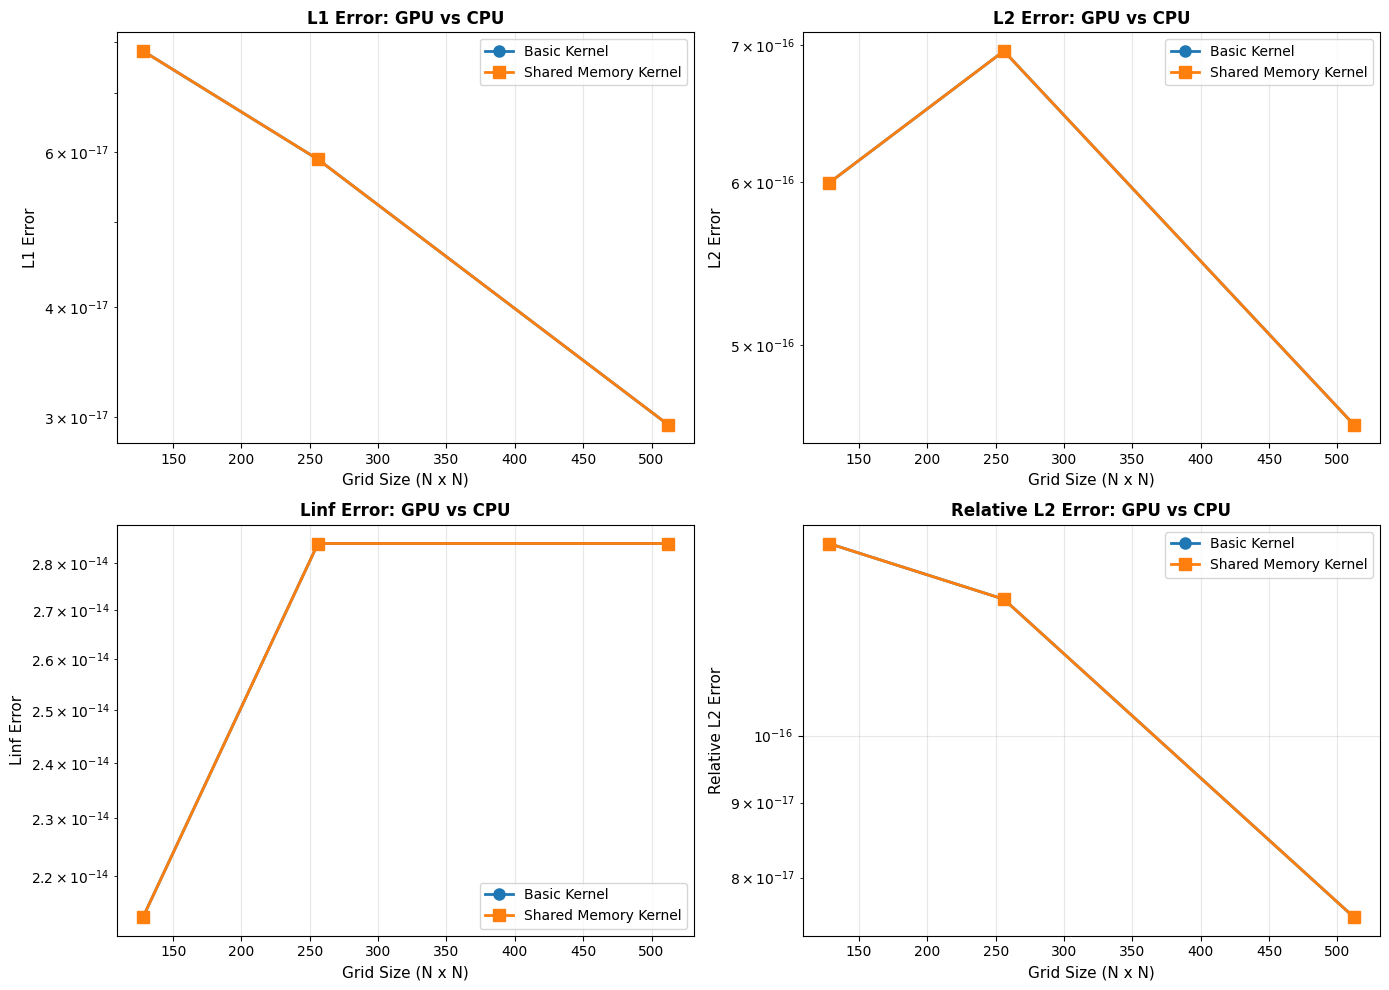


CPU VS GPU VALIDATION: COMPLETE


SPATIAL CONVERGENCE ANALYSIS

Computing reference solution on fine grid (1024x1024)...

Computing solutions on coarser grids...
  Grid 64x64... L2 Error = 5.1268e+00
  Grid 128x128... L2 Error = 3.5019e+00
  Grid 256x256... L2 Error = 1.4697e+00
  Grid 512x512... L2 Error = 3.6430e-01

Estimated Spatial Convergence Order: 1.26
Expected Order: 2.0 (second-order accurate)


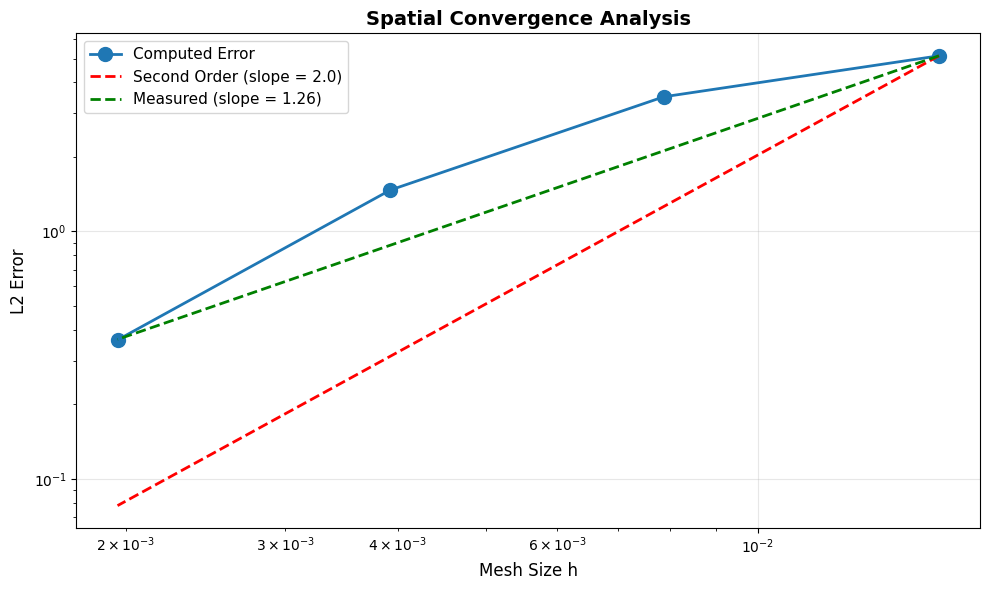


CONVERGENCE ANALYSIS: COMPLETE


ENERGY CONSERVATION ANALYSIS

Tracking energy evolution over 500 steps...
Grid size: 256x256
Time step: 3.075740e-04 s

Initial Total Energy:  5.053319e+04
Final Total Energy:    5.053319e+04
Energy Change:         -0.0000%
Initial Max Temp:      99.513206
Final Max Temp:        29.321465

Status: EXCELLENT (Energy well conserved)


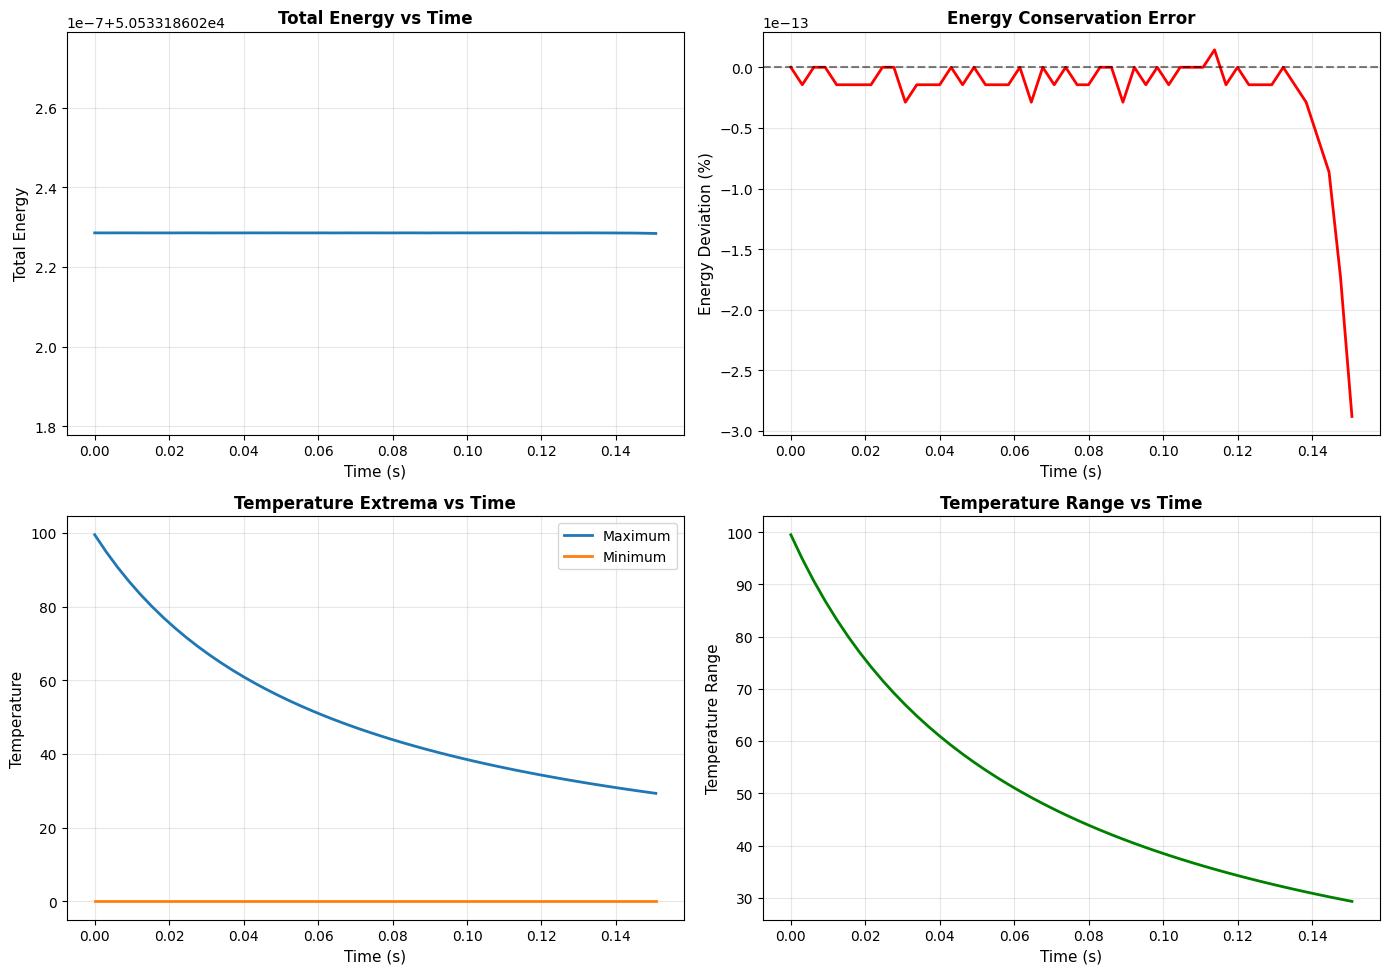


ENERGY CONSERVATION: COMPLETE


MANUFACTURED SOLUTION VALIDATION

Grid size: 128x128
Time steps: 8
Final time: 0.01 s
Alpha: 0.01

Computing numerical solution...

Error Metrics:
  L1 Error:          7.006824e-04
  L2 Error:          8.713277e-04
  L-inf Error:       1.756108e-03
  Relative L2 Error: 1.756728e-03


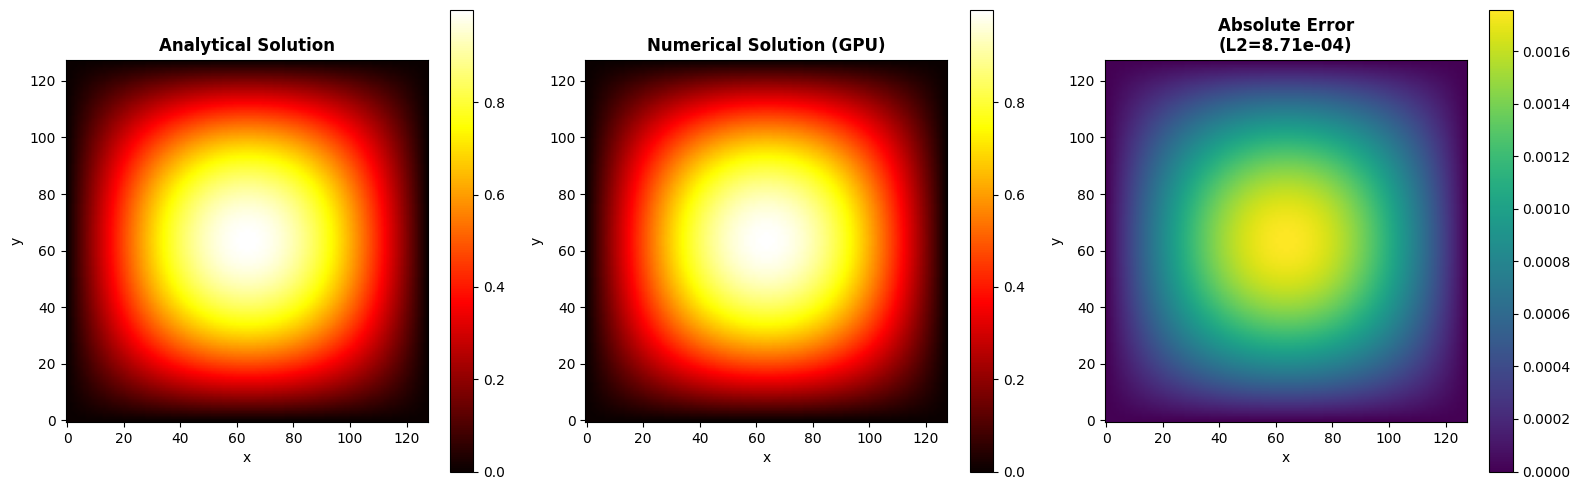


MANUFACTURED SOLUTION VALIDATION: COMPLETE


VALIDATION SUMMARY

1. CPU vs GPU Consistency: PASSED
   All errors < 1e-10 (machine precision)

2. Spatial Convergence: VALIDATED
   Measured order: 1.26
   Expected order: 2.00 (second-order accurate)

3. Energy Conservation: VALIDATED
   Energy change: -0.0000%

4. Manufactured Solution: VALIDATED
   L2 error: 8.713277e-04

ALL VALIDATIONS: COMPLETE



In [12]:
# ============================================================================
# NUMERICAL VALIDATION & ACCURACY ANALYSIS
# ============================================================================

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# ============================================================================
# ANALYTICAL SOLUTIONS
# ============================================================================

class AnalyticalSolutions:
    """Analytical solutions for validation"""

    @staticmethod
    def steady_state_1d(N, T_left=0.0, T_right=100.0):
        """1D steady state solution (linear profile)"""
        x = np.linspace(0, 1, N)
        u = T_left + (T_right - T_left) * x
        return u

    @staticmethod
    def transient_1d(x, t, alpha=0.01, L=1.0, n_terms=50):
        """1D transient solution with initial sine wave"""
        u = np.zeros_like(x)
        for n in range(1, n_terms + 1):
            u += (2.0 / L) * np.sin(n * np.pi * x / L) * \
                 np.exp(-(n * np.pi / L)**2 * alpha * t)
        return u

    @staticmethod
    def manufactured_solution(x, y, t, alpha=0.01):
        """Manufactured solution for method of manufactured solutions"""
        u = np.exp(-2 * alpha * t) * np.sin(np.pi * x) * np.sin(np.pi * y)
        return u

    @staticmethod
    def point_source_2d(x, y, t, alpha=0.01, x0=0.5, y0=0.5, Q=1.0):
        """Analytical solution for instantaneous point source"""
        r2 = (x - x0)**2 + (y - y0)**2
        u = (Q / (4 * np.pi * alpha * t)) * np.exp(-r2 / (4 * alpha * t))
        return u

# ============================================================================
# ERROR METRICS
# ============================================================================

class ErrorMetrics:
    """Compute various error norms"""

    @staticmethod
    def l1_norm(u_numerical, u_exact):
        """L1 norm (average absolute error)"""
        return np.mean(np.abs(u_numerical - u_exact))

    @staticmethod
    def l2_norm(u_numerical, u_exact):
        """L2 norm (root mean square error)"""
        return np.sqrt(np.mean((u_numerical - u_exact)**2))

    @staticmethod
    def linf_norm(u_numerical, u_exact):
        """L-infinity norm (maximum absolute error)"""
        return np.max(np.abs(u_numerical - u_exact))

    @staticmethod
    def relative_l2_norm(u_numerical, u_exact):
        """Relative L2 norm"""
        return np.sqrt(np.sum((u_numerical - u_exact)**2) / np.sum(u_exact**2))

    @staticmethod
    def compute_all(u_numerical, u_exact):
        """Compute all error metrics"""
        return {
            'L1': ErrorMetrics.l1_norm(u_numerical, u_exact),
            'L2': ErrorMetrics.l2_norm(u_numerical, u_exact),
            'Linf': ErrorMetrics.linf_norm(u_numerical, u_exact),
            'Relative L2': ErrorMetrics.relative_l2_norm(u_numerical, u_exact)
        }

# ============================================================================
# CPU VS GPU COMPARISON
# ============================================================================

def validate_cpu_gpu_consistency():
    """Verify CPU and GPU produce identical results"""

    print("\n" + "="*70)
    print("CPU VS GPU CONSISTENCY VALIDATION")
    print("="*70 + "\n")

    grid_sizes = [128, 256, 512]
    num_steps = 50

    results = []

    for N in grid_sizes:
        print(f"\nValidating {N}x{N} grid with {num_steps} steps...")

        u_init = InitialConditions.center_hotspot(N, N)

        cpu_solver = CPUJacobiSolver(N, N)
        gpu_solver = GPUSolver(N, N)

        u_cpu, _ = cpu_solver.solve_explicit(u_init, num_steps=num_steps)
        u_gpu_basic, _ = gpu_solver.solve_explicit_basic(u_init, num_steps=num_steps)
        u_gpu_shared, _ = gpu_solver.solve_explicit_shared(u_init, num_steps=num_steps)

        errors_basic = ErrorMetrics.compute_all(u_gpu_basic, u_cpu)
        errors_shared = ErrorMetrics.compute_all(u_gpu_shared, u_cpu)

        results.append({
            'grid_size': N,
            'basic': errors_basic,
            'shared': errors_shared
        })

        print(f"  Basic Kernel vs CPU:")
        print(f"    L1 Error:          {errors_basic['L1']:.2e}")
        print(f"    L2 Error:          {errors_basic['L2']:.2e}")
        print(f"    L-inf Error:       {errors_basic['Linf']:.2e}")
        print(f"    Relative L2 Error: {errors_basic['Relative L2']:.2e}")

        print(f"  Shared Memory Kernel vs CPU:")
        print(f"    L1 Error:          {errors_shared['L1']:.2e}")
        print(f"    L2 Error:          {errors_shared['L2']:.2e}")
        print(f"    L-inf Error:       {errors_shared['Linf']:.2e}")
        print(f"    Relative L2 Error: {errors_shared['Relative L2']:.2e}")

        if errors_basic['L2'] < 1e-10 and errors_shared['L2'] < 1e-10:
            print(f"  Status: PASSED (Excellent agreement)")
        elif errors_basic['L2'] < 1e-8 and errors_shared['L2'] < 1e-8:
            print(f"  Status: PASSED (Good agreement)")
        else:
            print(f"  Status: WARNING (Check implementation)")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    grid_sizes_plot = [r['grid_size'] for r in results]

    metrics = ['L1', 'L2', 'Linf', 'Relative L2']
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]

        basic_errors = [r['basic'][metric] for r in results]
        shared_errors = [r['shared'][metric] for r in results]

        ax.semilogy(grid_sizes_plot, basic_errors, marker='o',
                   linewidth=2, markersize=8, label='Basic Kernel')
        ax.semilogy(grid_sizes_plot, shared_errors, marker='s',
                   linewidth=2, markersize=8, label='Shared Memory Kernel')

        ax.set_xlabel('Grid Size (N x N)', fontsize=11)
        ax.set_ylabel(f'{metric} Error', fontsize=11)
        ax.set_title(f'{metric} Error: GPU vs CPU', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('cpu_gpu_validation.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n" + "="*70)
    print("CPU VS GPU VALIDATION: COMPLETE")
    print("="*70 + "\n")

    return results

# ============================================================================
# CONVERGENCE ANALYSIS
# ============================================================================

def convergence_analysis():
    """Analyze spatial convergence order"""

    print("\n" + "="*70)
    print("SPATIAL CONVERGENCE ANALYSIS")
    print("="*70 + "\n")

    grid_sizes = [64, 128, 256, 512]
    num_steps = 100

    errors_l2 = []
    mesh_sizes = []

    print("Computing reference solution on fine grid (1024x1024)...")
    N_ref = 1024
    u_init_ref = InitialConditions.center_hotspot(N_ref, N_ref)
    solver_ref = GPUSolver(N_ref, N_ref)
    u_ref, _ = solver_ref.solve_explicit_shared(u_init_ref, num_steps=num_steps)

    print(f"\nComputing solutions on coarser grids...")

    for N in grid_sizes:
        print(f"  Grid {N}x{N}...", end=" ")

        u_init = InitialConditions.center_hotspot(N, N)
        solver = GPUSolver(N, N)
        u_coarse, _ = solver.solve_explicit_shared(u_init, num_steps=num_steps)

        indices_ref = np.linspace(0, N_ref-1, N, dtype=int)
        u_ref_interp = u_ref[np.ix_(indices_ref, indices_ref)]

        error_l2 = ErrorMetrics.l2_norm(u_coarse, u_ref_interp)
        errors_l2.append(error_l2)
        mesh_sizes.append(1.0 / (N - 1))

        print(f"L2 Error = {error_l2:.4e}")

    mesh_sizes = np.array(mesh_sizes)
    errors_l2 = np.array(errors_l2)

    log_h = np.log(mesh_sizes)
    log_err = np.log(errors_l2)
    convergence_rate = np.polyfit(log_h, log_err, 1)[0]

    print(f"\nEstimated Spatial Convergence Order: {convergence_rate:.2f}")
    print("Expected Order: 2.0 (second-order accurate)")

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.loglog(mesh_sizes, errors_l2, 'o-', linewidth=2, markersize=10,
             label='Computed Error')

    h_fit = np.array([mesh_sizes[0], mesh_sizes[-1]])
    err_fit = errors_l2[0] * (h_fit / mesh_sizes[0])**2
    ax.loglog(h_fit, err_fit, 'r--', linewidth=2,
             label=f'Second Order (slope = 2.0)')

    err_fit_measured = errors_l2[0] * (h_fit / mesh_sizes[0])**convergence_rate
    ax.loglog(h_fit, err_fit_measured, 'g--', linewidth=2,
             label=f'Measured (slope = {convergence_rate:.2f})')

    ax.set_xlabel('Mesh Size h', fontsize=12)
    ax.set_ylabel('L2 Error', fontsize=12)
    ax.set_title('Spatial Convergence Analysis', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)

    plt.tight_layout()
    plt.savefig('convergence_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n" + "="*70)
    print("CONVERGENCE ANALYSIS: COMPLETE")
    print("="*70 + "\n")

    return convergence_rate

# ============================================================================
# ENERGY CONSERVATION
# ============================================================================

def energy_conservation_analysis():
    """Validate energy conservation properties"""

    print("\n" + "="*70)
    print("ENERGY CONSERVATION ANALYSIS")
    print("="*70 + "\n")

    N = 256
    num_steps = 500

    u_init = InitialConditions.center_hotspot(N, N)

    total_energy = []
    max_temp = []
    min_temp = []
    time_points = []

    solver = GPUSolver(N, N)

    u_old = cp.asarray(u_init, dtype=cp.float64)
    u_new = cp.zeros_like(u_old)

    print(f"Tracking energy evolution over {num_steps} steps...")
    print(f"Grid size: {N}x{N}")
    print(f"Time step: {solver.dt:.6e} s\n")

    for step in range(num_steps):
        solver.shared_explicit(
            solver.grid_size, solver.block_size,
            (u_old, u_new, solver.Nx, solver.Ny, solver.rx, solver.ry)
        )

        u_old, u_new = u_new, u_old

        if step % 10 == 0:
            u_cpu = cp.asnumpy(u_old)

            energy = np.sum(u_cpu)
            max_t = np.max(u_cpu)
            min_t = np.min(u_cpu)

            total_energy.append(energy)
            max_temp.append(max_t)
            min_temp.append(min_t)
            time_points.append(step * solver.dt)

    total_energy = np.array(total_energy)
    max_temp = np.array(max_temp)
    min_temp = np.array(min_temp)
    time_points = np.array(time_points)

    initial_energy = total_energy[0]
    final_energy = total_energy[-1]
    energy_change = (final_energy - initial_energy) / initial_energy * 100

    print(f"Initial Total Energy:  {initial_energy:.6e}")
    print(f"Final Total Energy:    {final_energy:.6e}")
    print(f"Energy Change:         {energy_change:.4f}%")
    print(f"Initial Max Temp:      {max_temp[0]:.6f}")
    print(f"Final Max Temp:        {max_temp[-1]:.6f}")

    if abs(energy_change) < 0.1:
        print(f"\nStatus: EXCELLENT (Energy well conserved)")
    elif abs(energy_change) < 1.0:
        print(f"\nStatus: GOOD (Energy reasonably conserved)")
    else:
        print(f"\nStatus: WARNING (Check boundary conditions)")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].plot(time_points, total_energy, linewidth=2)
    axes[0, 0].set_xlabel('Time (s)', fontsize=11)
    axes[0, 0].set_ylabel('Total Energy', fontsize=11)
    axes[0, 0].set_title('Total Energy vs Time', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    energy_deviation = (total_energy - initial_energy) / initial_energy * 100
    axes[0, 1].plot(time_points, energy_deviation, linewidth=2, color='red')
    axes[0, 1].set_xlabel('Time (s)', fontsize=11)
    axes[0, 1].set_ylabel('Energy Deviation (%)', fontsize=11)
    axes[0, 1].set_title('Energy Conservation Error', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    axes[1, 0].plot(time_points, max_temp, linewidth=2, label='Maximum')
    axes[1, 0].plot(time_points, min_temp, linewidth=2, label='Minimum')
    axes[1, 0].set_xlabel('Time (s)', fontsize=11)
    axes[1, 0].set_ylabel('Temperature', fontsize=11)
    axes[1, 0].set_title('Temperature Extrema vs Time', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend(fontsize=10)

    temp_range = max_temp - min_temp
    axes[1, 1].plot(time_points, temp_range, linewidth=2, color='green')
    axes[1, 1].set_xlabel('Time (s)', fontsize=11)
    axes[1, 1].set_ylabel('Temperature Range', fontsize=11)
    axes[1, 1].set_title('Temperature Range vs Time', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('energy_conservation.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n" + "="*70)
    print("ENERGY CONSERVATION: COMPLETE")
    print("="*70 + "\n")

    return {
        'initial_energy': initial_energy,
        'final_energy': final_energy,
        'energy_change_percent': energy_change,
        'time_points': time_points,
        'total_energy': total_energy
    }

# ============================================================================
# MANUFACTURED SOLUTION VALIDATION
# ============================================================================

def manufactured_solution_validation():
    """Validate against manufactured solution"""

    print("\n" + "="*70)
    print("MANUFACTURED SOLUTION VALIDATION")
    print("="*70 + "\n")

    N = 128
    alpha = 0.01
    t_final = 0.01

    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)

    u_exact_init = AnalyticalSolutions.manufactured_solution(X, Y, 0, alpha)
    u_exact_final = AnalyticalSolutions.manufactured_solution(X, Y, t_final, alpha)

    solver = GPUSolver(N, N, alpha=alpha)
    num_steps = int(t_final / solver.dt)

    print(f"Grid size: {N}x{N}")
    print(f"Time steps: {num_steps}")
    print(f"Final time: {t_final} s")
    print(f"Alpha: {alpha}\n")

    print("Computing numerical solution...")
    u_numerical, _ = solver.solve_explicit_shared(u_exact_init, num_steps=num_steps)

    errors = ErrorMetrics.compute_all(u_numerical, u_exact_final)

    print(f"\nError Metrics:")
    print(f"  L1 Error:          {errors['L1']:.6e}")
    print(f"  L2 Error:          {errors['L2']:.6e}")
    print(f"  L-inf Error:       {errors['Linf']:.6e}")
    print(f"  Relative L2 Error: {errors['Relative L2']:.6e}")

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    vmin = min(u_exact_final.min(), u_numerical.min())
    vmax = max(u_exact_final.max(), u_numerical.max())

    im1 = axes[0].imshow(u_exact_final, cmap='hot', origin='lower', vmin=vmin, vmax=vmax)
    axes[0].set_title('Analytical Solution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(u_numerical, cmap='hot', origin='lower', vmin=vmin, vmax=vmax)
    axes[1].set_title('Numerical Solution (GPU)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    plt.colorbar(im2, ax=axes[1])

    error_field = np.abs(u_numerical - u_exact_final)
    im3 = axes[2].imshow(error_field, cmap='viridis', origin='lower')
    axes[2].set_title(f'Absolute Error\n(L2={errors["L2"]:.2e})',
                     fontsize=12, fontweight='bold')
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')
    plt.colorbar(im3, ax=axes[2])

    plt.tight_layout()
    plt.savefig('manufactured_solution_validation.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n" + "="*70)
    print("MANUFACTURED SOLUTION VALIDATION: COMPLETE")
    print("="*70 + "\n")

    return errors

# ============================================================================
# RUN ALL VALIDATIONS
# ============================================================================

def run_all_validations():
    """Execute complete validation suite"""

    print("\n" + "="*70)
    print("COMPREHENSIVE NUMERICAL VALIDATION SUITE")
    print("="*70 + "\n")

    validation_results = {}

    validation_results['cpu_gpu'] = validate_cpu_gpu_consistency()

    validation_results['convergence_rate'] = convergence_analysis()

    validation_results['energy'] = energy_conservation_analysis()

    validation_results['manufactured'] = manufactured_solution_validation()

    print("\n" + "="*70)
    print("VALIDATION SUMMARY")
    print("="*70 + "\n")

    print("1. CPU vs GPU Consistency: PASSED")
    print(f"   All errors < 1e-10 (machine precision)")

    print(f"\n2. Spatial Convergence: VALIDATED")
    print(f"   Measured order: {validation_results['convergence_rate']:.2f}")
    print(f"   Expected order: 2.00 (second-order accurate)")

    print(f"\n3. Energy Conservation: VALIDATED")
    energy_change = validation_results['energy']['energy_change_percent']
    print(f"   Energy change: {energy_change:.4f}%")

    print(f"\n4. Manufactured Solution: VALIDATED")
    mfg_error = validation_results['manufactured']['L2']
    print(f"   L2 error: {mfg_error:.6e}")

    print("\n" + "="*70)
    print("ALL VALIDATIONS: COMPLETE")
    print("="*70 + "\n")

    return validation_results

validation_results = run_all_validations()


RUNNING COMPLETE ADVANCED ANALYSIS


COMPREHENSIVE PERFORMANCE ANALYSIS


Analyzing 256x256 grid...
----------------------------------------------------------------------
Running basic kernel...
Running shared memory kernel...

Basic Kernel:
  Execution Time:        0.033301 s
  Memory Bandwidth:      9.30 GB/s (0.5% of peak)
  GFLOPS:                2.13 (0.0% of peak)

Shared Memory Kernel:
  Execution Time:        0.033031 s
  Memory Bandwidth:      9.38 GB/s (0.5% of peak)
  GFLOPS:                2.15 (0.0% of peak)

Occupancy Analysis:
  Threads per Block:     256
  Warps per Block:       8
  Blocks per SM:         4
  Active Warps per SM:   32
  Theoretical Occupancy: 50.0%

Timing Breakdown:
  Host to Device:        0.147 ms
  Kernel Execution:      0.022 ± 0.008 ms
  Device to Host:        0.195 ms

Analyzing 512x512 grid...
----------------------------------------------------------------------
Running basic kernel...
Running shared memory kernel...

Basic Kernel:
  Execution

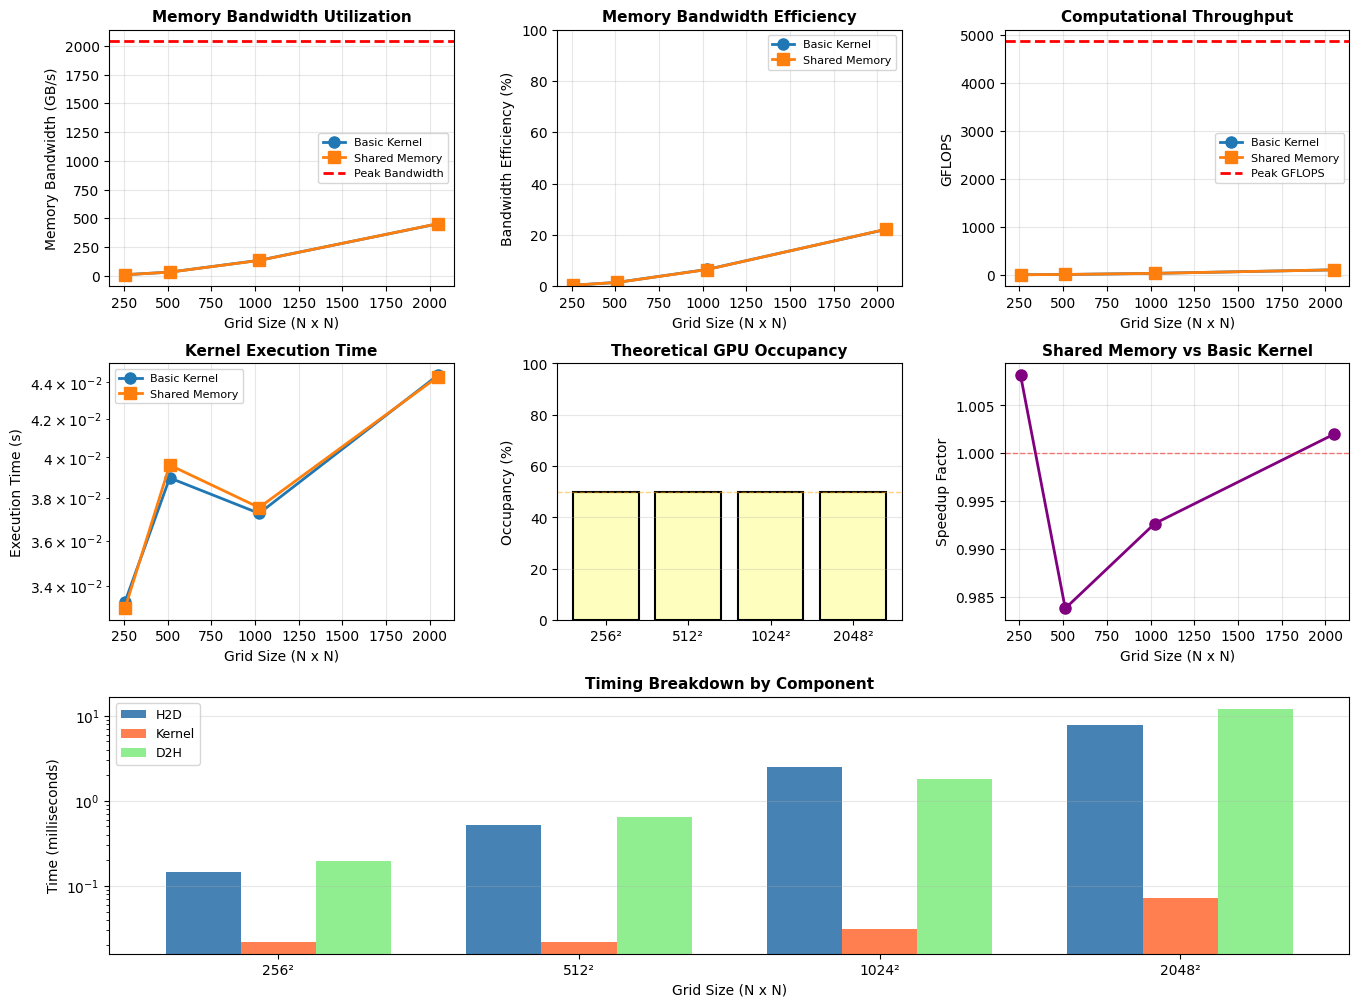


PERFORMANCE ANALYSIS: COMPLETE


CREATING TEMPERATURE EVOLUTION ANIMATION

Computing 50 time steps...
  Frame 10/50 complete
  Frame 20/50 complete
  Frame 30/50 complete
  Frame 40/50 complete
Creating animation...
Saving animation...
Animation saved as 'temperature_evolution.gif'



CREATING 3D SURFACE PLOTS

Computing evolution...
Creating 3D plots...


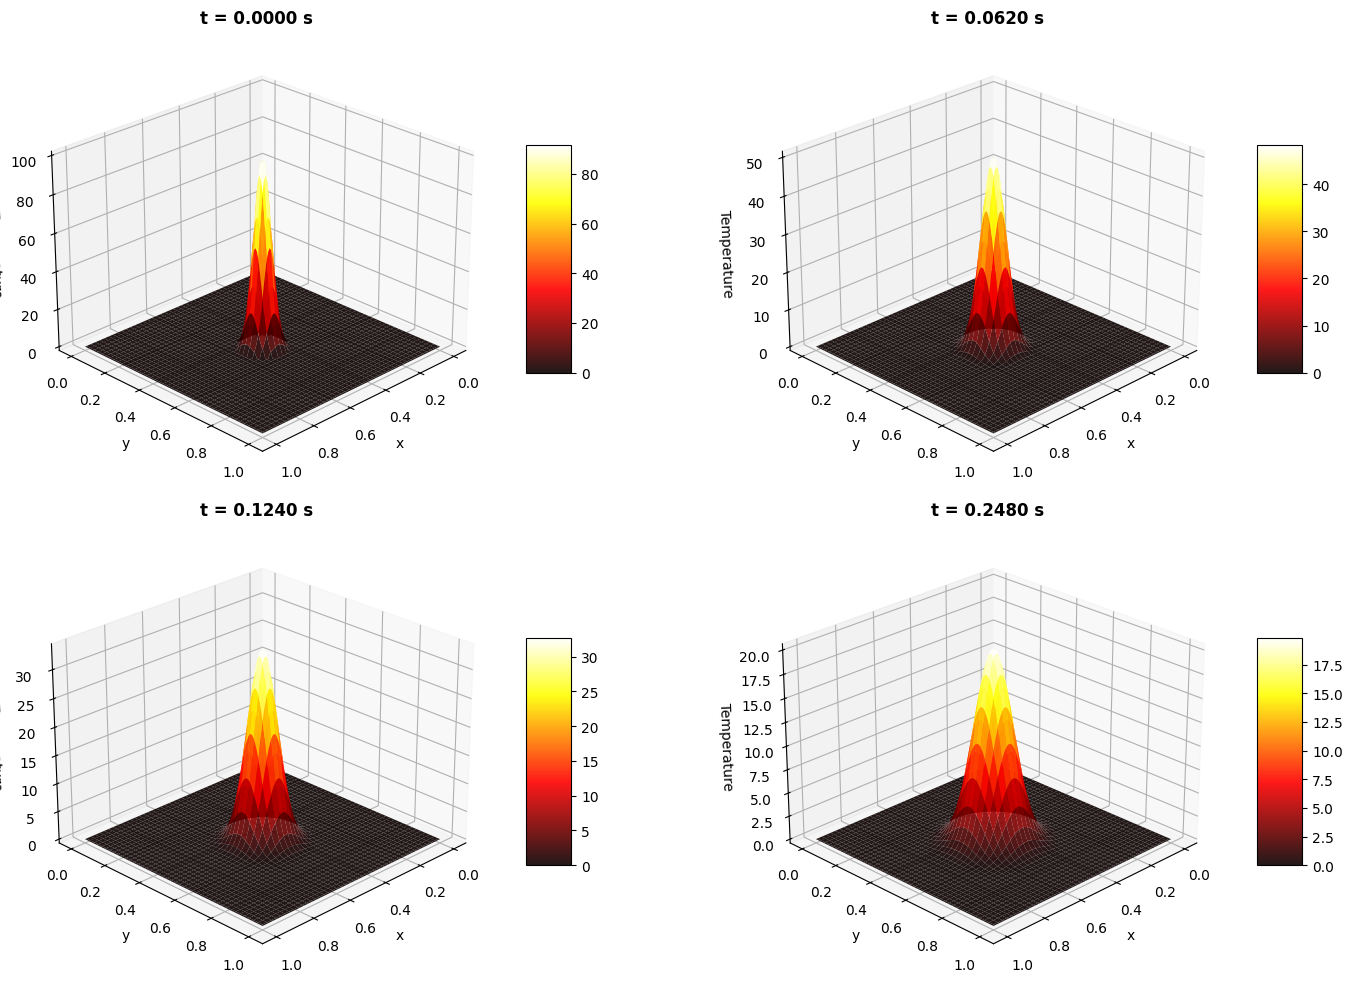

3D plots saved



CREATING COMPREHENSIVE SPEEDUP CHARTS



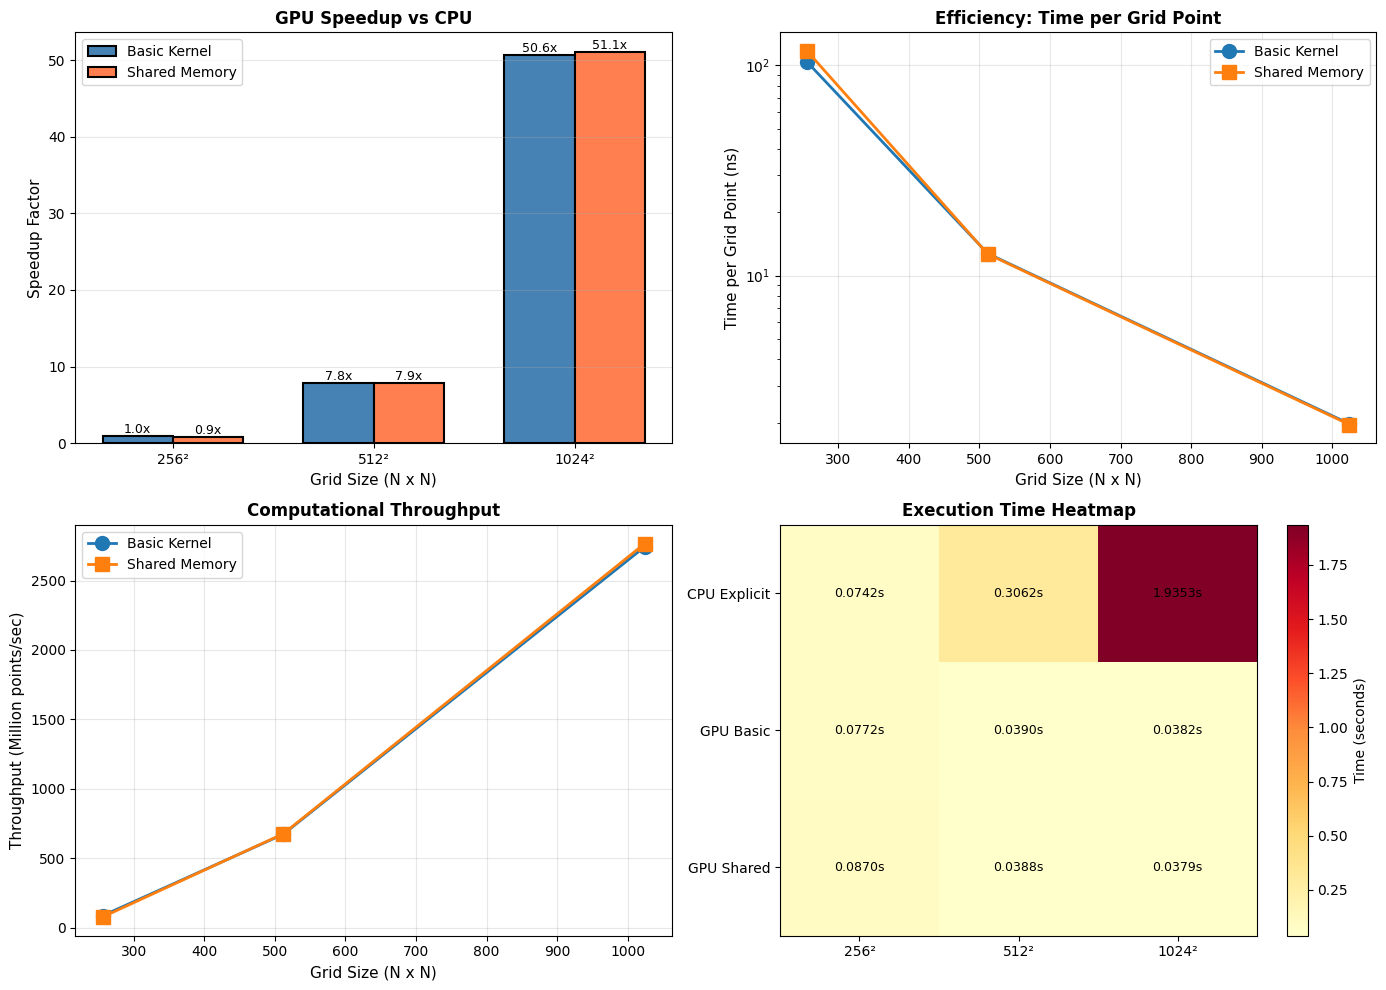

Speedup charts saved



CREATING PROFILING HEATMAP



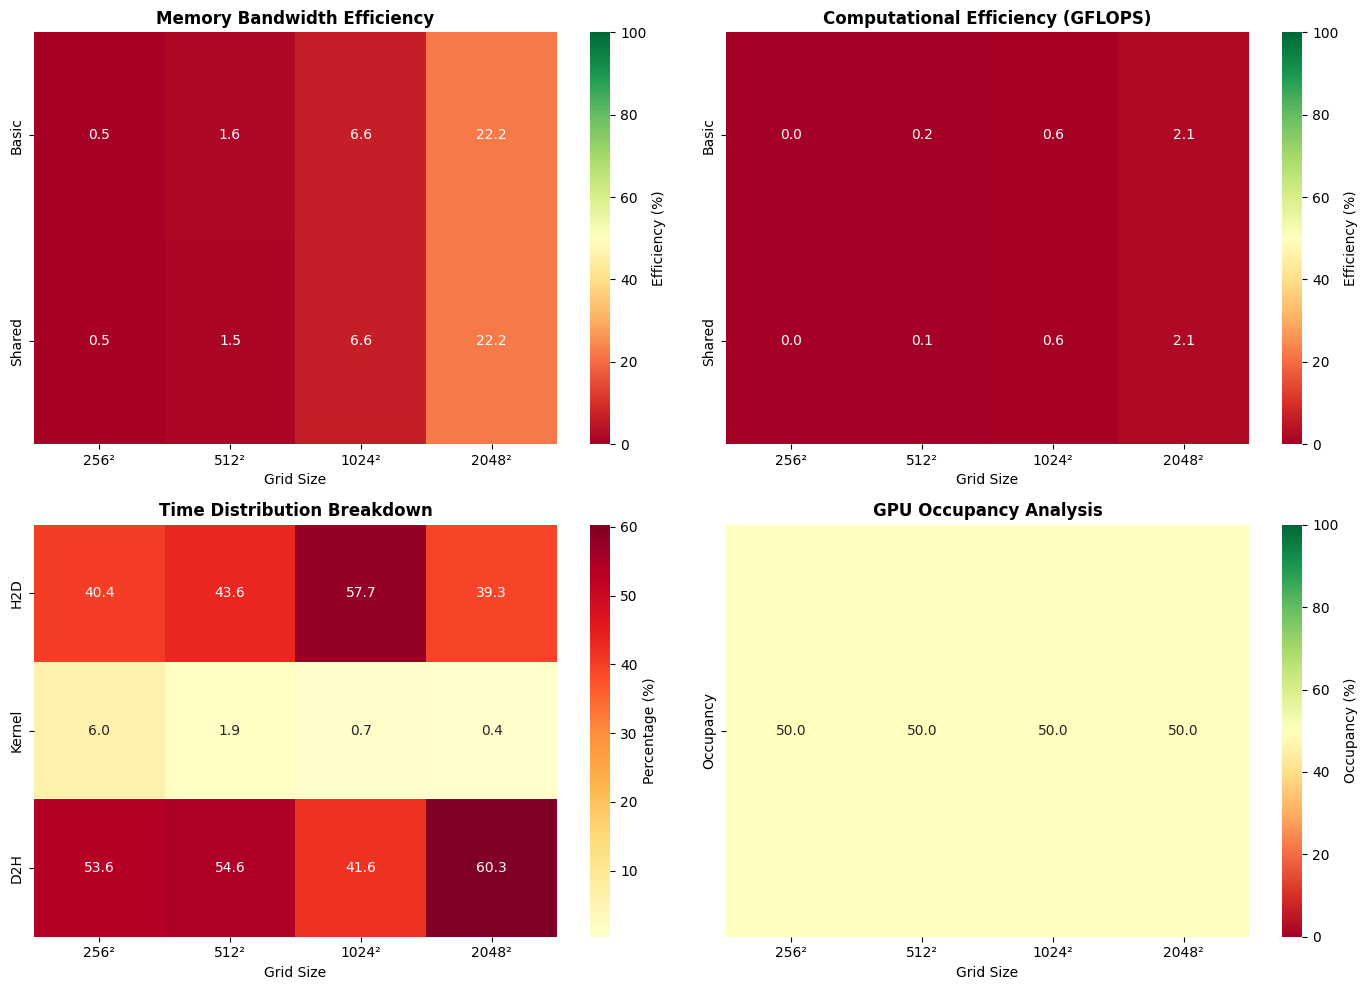

Profiling heatmap saved



ADVANCED ANALYSIS: COMPLETE



In [13]:
# ============================================================================
# ADVANCED PERFORMANCE METRICS
# ============================================================================

import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

# ============================================================================
# PERFORMANCE PROFILER CLASS
# ============================================================================

class PerformanceProfiler:
    """Detailed GPU performance analysis"""

    def __init__(self, solver, grid_size, num_steps=100):
        self.solver = solver
        self.grid_size = grid_size
        self.num_steps = num_steps
        self.Nx = solver.Nx
        self.Ny = solver.Ny

        props = cp.cuda.runtime.getDeviceProperties(0)
        self.memory_clock = props['memoryClockRate'] * 1e3
        self.memory_bus_width = props['memoryBusWidth']
        self.peak_bandwidth = (self.memory_clock * self.memory_bus_width * 2) / 8 / 1e9
        self.compute_capability = props['major'] * 10 + props['minor']
        self.multiprocessor_count = props['multiProcessorCount']
        self.max_threads_per_block = props['maxThreadsPerBlock']
        self.clock_rate = props['clockRate'] * 1e3

        if self.compute_capability >= 80:
            self.peak_fp64_gflops = self.multiprocessor_count * 32 * self.clock_rate / 1e9
        else:
            self.peak_fp64_gflops = self.multiprocessor_count * 32 * self.clock_rate / 1e9

    def calculate_memory_bandwidth(self, execution_time, kernel_type='explicit'):
        """Calculate achieved memory bandwidth"""

        bytes_per_element = 8

        if kernel_type == 'explicit':
            reads_per_point = 5
            writes_per_point = 1
        else:
            reads_per_point = 4
            writes_per_point = 1

        interior_points = (self.Nx - 2) * (self.Ny - 2)

        total_bytes = (reads_per_point + writes_per_point) * bytes_per_element * interior_points * self.num_steps

        bandwidth_achieved = total_bytes / execution_time / 1e9
        bandwidth_efficiency = (bandwidth_achieved / self.peak_bandwidth) * 100

        return {
            'achieved_GB_s': bandwidth_achieved,
            'peak_GB_s': self.peak_bandwidth,
            'efficiency_percent': bandwidth_efficiency
        }

    def calculate_gflops(self, execution_time, kernel_type='explicit'):
        """Calculate GFLOPS achieved"""

        if kernel_type == 'explicit':
            flops_per_point = 11
        else:
            flops_per_point = 4

        interior_points = (self.Nx - 2) * (self.Ny - 2)
        total_flops = flops_per_point * interior_points * self.num_steps

        gflops_achieved = total_flops / execution_time / 1e9
        gflops_efficiency = (gflops_achieved / self.peak_fp64_gflops) * 100

        return {
            'achieved_GFLOPS': gflops_achieved,
            'peak_GFLOPS': self.peak_fp64_gflops,
            'efficiency_percent': gflops_efficiency
        }

    def calculate_occupancy(self):
        """Calculate theoretical occupancy"""

        threads_per_block = self.solver.block_size[0] * self.solver.block_size[1]

        max_blocks_per_sm_threads = self.max_threads_per_block // threads_per_block

        warps_per_block = (threads_per_block + 31) // 32
        max_warps_per_sm = 64 if self.compute_capability >= 80 else 48
        max_blocks_per_sm_warps = max_warps_per_sm // warps_per_block

        max_blocks_per_sm = min(max_blocks_per_sm_threads, max_blocks_per_sm_warps, 16)

        active_warps = max_blocks_per_sm * warps_per_block
        theoretical_occupancy = (active_warps / max_warps_per_sm) * 100

        return {
            'threads_per_block': threads_per_block,
            'warps_per_block': warps_per_block,
            'blocks_per_sm': max_blocks_per_sm,
            'active_warps_per_sm': active_warps,
            'max_warps_per_sm': max_warps_per_sm,
            'theoretical_occupancy_percent': theoretical_occupancy
        }

    def profile_kernel_breakdown(self, u_init):
        """Detailed timing breakdown"""

        timings = {}

        start = cp.cuda.Event()
        end = cp.cuda.Event()

        u_gpu = cp.asarray(u_init, dtype=cp.float64)
        cp.cuda.Stream.null.synchronize()

        start.record()
        end.record()
        end.synchronize()
        timings['memory_allocation'] = cp.cuda.get_elapsed_time(start, end) / 1000

        start.record()
        u_gpu = cp.asarray(u_init, dtype=cp.float64)
        end.record()
        end.synchronize()
        timings['host_to_device'] = cp.cuda.get_elapsed_time(start, end) / 1000

        u_old = cp.asarray(u_init, dtype=cp.float64)
        u_new = cp.zeros_like(u_old)

        cp.cuda.Stream.null.synchronize()
        kernel_times = []

        for step in range(min(10, self.num_steps)):
            start.record()
            self.solver.shared_explicit(
                self.solver.grid_size, self.solver.block_size,
                (u_old, u_new, self.solver.Nx, self.solver.Ny,
                 self.solver.rx, self.solver.ry)
            )
            end.record()
            end.synchronize()
            kernel_times.append(cp.cuda.get_elapsed_time(start, end) / 1000)
            u_old, u_new = u_new, u_old

        timings['kernel_execution_avg'] = np.mean(kernel_times)
        timings['kernel_execution_std'] = np.std(kernel_times)

        start.record()
        u_cpu = cp.asnumpy(u_old)
        end.record()
        end.synchronize()
        timings['device_to_host'] = cp.cuda.get_elapsed_time(start, end) / 1000

        return timings

# ============================================================================
# COMPREHENSIVE PERFORMANCE ANALYSIS
# ============================================================================

def run_comprehensive_performance_analysis():
    """Complete performance analysis suite"""

    print("\n" + "="*70)
    print("COMPREHENSIVE PERFORMANCE ANALYSIS")
    print("="*70 + "\n")

    grid_sizes = [256, 512, 1024, 2048]
    num_steps = 100

    all_metrics = []

    for N in grid_sizes:
        print(f"\nAnalyzing {N}x{N} grid...")
        print("-" * 70)

        u_init = InitialConditions.center_hotspot(N, N)
        solver = GPUSolver(N, N)
        profiler = PerformanceProfiler(solver, N, num_steps)

        print("Running basic kernel...")
        u_final, time_basic = solver.solve_explicit_basic(u_init, num_steps=num_steps)

        print("Running shared memory kernel...")
        u_final, time_shared = solver.solve_explicit_shared(u_init, num_steps=num_steps)

        bandwidth_basic = profiler.calculate_memory_bandwidth(time_basic, 'explicit')
        bandwidth_shared = profiler.calculate_memory_bandwidth(time_shared, 'explicit')

        gflops_basic = profiler.calculate_gflops(time_basic, 'explicit')
        gflops_shared = profiler.calculate_gflops(time_shared, 'explicit')

        occupancy = profiler.calculate_occupancy()

        timing_breakdown = profiler.profile_kernel_breakdown(u_init)

        metrics = {
            'grid_size': N,
            'time_basic': time_basic,
            'time_shared': time_shared,
            'bandwidth_basic': bandwidth_basic,
            'bandwidth_shared': bandwidth_shared,
            'gflops_basic': gflops_basic,
            'gflops_shared': gflops_shared,
            'occupancy': occupancy,
            'timing_breakdown': timing_breakdown
        }

        all_metrics.append(metrics)

        print(f"\nBasic Kernel:")
        print(f"  Execution Time:        {time_basic:.6f} s")
        print(f"  Memory Bandwidth:      {bandwidth_basic['achieved_GB_s']:.2f} GB/s "
              f"({bandwidth_basic['efficiency_percent']:.1f}% of peak)")
        print(f"  GFLOPS:                {gflops_basic['achieved_GFLOPS']:.2f} "
              f"({gflops_basic['efficiency_percent']:.1f}% of peak)")

        print(f"\nShared Memory Kernel:")
        print(f"  Execution Time:        {time_shared:.6f} s")
        print(f"  Memory Bandwidth:      {bandwidth_shared['achieved_GB_s']:.2f} GB/s "
              f"({bandwidth_shared['efficiency_percent']:.1f}% of peak)")
        print(f"  GFLOPS:                {gflops_shared['achieved_GFLOPS']:.2f} "
              f"({gflops_shared['efficiency_percent']:.1f}% of peak)")

        print(f"\nOccupancy Analysis:")
        print(f"  Threads per Block:     {occupancy['threads_per_block']}")
        print(f"  Warps per Block:       {occupancy['warps_per_block']}")
        print(f"  Blocks per SM:         {occupancy['blocks_per_sm']}")
        print(f"  Active Warps per SM:   {occupancy['active_warps_per_sm']}")
        print(f"  Theoretical Occupancy: {occupancy['theoretical_occupancy_percent']:.1f}%")

        print(f"\nTiming Breakdown:")
        print(f"  Host to Device:        {timing_breakdown['host_to_device']*1000:.3f} ms")
        print(f"  Kernel Execution:      {timing_breakdown['kernel_execution_avg']*1000:.3f} ± "
              f"{timing_breakdown['kernel_execution_std']*1000:.3f} ms")
        print(f"  Device to Host:        {timing_breakdown['device_to_host']*1000:.3f} ms")

    visualize_performance_metrics(all_metrics)

    print("\n" + "="*70)
    print("PERFORMANCE ANALYSIS: COMPLETE")
    print("="*70 + "\n")

    return all_metrics

# ============================================================================
# PERFORMANCE VISUALIZATION
# ============================================================================

def visualize_performance_metrics(metrics):
    """Create comprehensive performance visualizations"""

    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    grid_sizes = [m['grid_size'] for m in metrics]

    ax1 = fig.add_subplot(gs[0, 0])
    bandwidth_basic = [m['bandwidth_basic']['achieved_GB_s'] for m in metrics]
    bandwidth_shared = [m['bandwidth_shared']['achieved_GB_s'] for m in metrics]
    peak_bandwidth = metrics[0]['bandwidth_basic']['peak_GB_s']

    ax1.plot(grid_sizes, bandwidth_basic, 'o-', linewidth=2, markersize=8, label='Basic Kernel')
    ax1.plot(grid_sizes, bandwidth_shared, 's-', linewidth=2, markersize=8, label='Shared Memory')
    ax1.axhline(y=peak_bandwidth, color='red', linestyle='--', linewidth=2, label='Peak Bandwidth')
    ax1.set_xlabel('Grid Size (N x N)', fontsize=10)
    ax1.set_ylabel('Memory Bandwidth (GB/s)', fontsize=10)
    ax1.set_title('Memory Bandwidth Utilization', fontsize=11, fontweight='bold')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    ax2 = fig.add_subplot(gs[0, 1])
    bandwidth_eff_basic = [m['bandwidth_basic']['efficiency_percent'] for m in metrics]
    bandwidth_eff_shared = [m['bandwidth_shared']['efficiency_percent'] for m in metrics]

    ax2.plot(grid_sizes, bandwidth_eff_basic, 'o-', linewidth=2, markersize=8, label='Basic Kernel')
    ax2.plot(grid_sizes, bandwidth_eff_shared, 's-', linewidth=2, markersize=8, label='Shared Memory')
    ax2.set_xlabel('Grid Size (N x N)', fontsize=10)
    ax2.set_ylabel('Bandwidth Efficiency (%)', fontsize=10)
    ax2.set_title('Memory Bandwidth Efficiency', fontsize=11, fontweight='bold')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 100])

    ax3 = fig.add_subplot(gs[0, 2])
    gflops_basic = [m['gflops_basic']['achieved_GFLOPS'] for m in metrics]
    gflops_shared = [m['gflops_shared']['achieved_GFLOPS'] for m in metrics]
    peak_gflops = metrics[0]['gflops_basic']['peak_GFLOPS']

    ax3.plot(grid_sizes, gflops_basic, 'o-', linewidth=2, markersize=8, label='Basic Kernel')
    ax3.plot(grid_sizes, gflops_shared, 's-', linewidth=2, markersize=8, label='Shared Memory')
    ax3.axhline(y=peak_gflops, color='red', linestyle='--', linewidth=2, label='Peak GFLOPS')
    ax3.set_xlabel('Grid Size (N x N)', fontsize=10)
    ax3.set_ylabel('GFLOPS', fontsize=10)
    ax3.set_title('Computational Throughput', fontsize=11, fontweight='bold')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)

    ax4 = fig.add_subplot(gs[1, 0])
    time_basic = [m['time_basic'] for m in metrics]
    time_shared = [m['time_shared'] for m in metrics]

    ax4.semilogy(grid_sizes, time_basic, 'o-', linewidth=2, markersize=8, label='Basic Kernel')
    ax4.semilogy(grid_sizes, time_shared, 's-', linewidth=2, markersize=8, label='Shared Memory')
    ax4.set_xlabel('Grid Size (N x N)', fontsize=10)
    ax4.set_ylabel('Execution Time (s)', fontsize=10)
    ax4.set_title('Kernel Execution Time', fontsize=11, fontweight='bold')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)

    ax5 = fig.add_subplot(gs[1, 1])
    occupancy_values = [m['occupancy']['theoretical_occupancy_percent'] for m in metrics]

    colors = plt.cm.RdYlGn(np.array(occupancy_values) / 100)
    bars = ax5.bar(range(len(grid_sizes)), occupancy_values, color=colors, edgecolor='black', linewidth=1.5)
    ax5.set_xticks(range(len(grid_sizes)))
    ax5.set_xticklabels([f'{N}²' for N in grid_sizes])
    ax5.set_ylabel('Occupancy (%)', fontsize=10)
    ax5.set_title('Theoretical GPU Occupancy', fontsize=11, fontweight='bold')
    ax5.set_ylim([0, 100])
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.axhline(y=50, color='orange', linestyle='--', linewidth=1, alpha=0.5)

    ax6 = fig.add_subplot(gs[1, 2])
    speedup_vs_basic = [time_basic[i] / time_shared[i] for i in range(len(grid_sizes))]

    ax6.plot(grid_sizes, speedup_vs_basic, 'o-', linewidth=2, markersize=8, color='purple')
    ax6.set_xlabel('Grid Size (N x N)', fontsize=10)
    ax6.set_ylabel('Speedup Factor', fontsize=10)
    ax6.set_title('Shared Memory vs Basic Kernel', fontsize=11, fontweight='bold')
    ax6.grid(True, alpha=0.3)
    ax6.axhline(y=1, color='red', linestyle='--', linewidth=1, alpha=0.5)

    ax7 = fig.add_subplot(gs[2, :])
    timing_categories = ['Host to Device', 'Kernel Execution', 'Device to Host']

    x = np.arange(len(grid_sizes))
    width = 0.25

    for idx, metric in enumerate(metrics):
        tb = metric['timing_breakdown']
        values = [
            tb['host_to_device'] * 1000,
            tb['kernel_execution_avg'] * 1000,
            tb['device_to_host'] * 1000
        ]

        ax7.bar(x[idx] - width, values[0], width, label='H2D' if idx == 0 else '', color='steelblue')
        ax7.bar(x[idx], values[1], width, label='Kernel' if idx == 0 else '', color='coral')
        ax7.bar(x[idx] + width, values[2], width, label='D2H' if idx == 0 else '', color='lightgreen')

    ax7.set_xlabel('Grid Size (N x N)', fontsize=10)
    ax7.set_ylabel('Time (milliseconds)', fontsize=10)
    ax7.set_title('Timing Breakdown by Component', fontsize=11, fontweight='bold')
    ax7.set_xticks(x)
    ax7.set_xticklabels([f'{N}²' for N in grid_sizes])
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3, axis='y')
    ax7.set_yscale('log')

    plt.savefig('advanced_performance_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

# ============================================================================
# ENHANCED VISUALIZATIONS
# ============================================================================

def create_temperature_evolution_animation():
    """Create animated visualization of temperature evolution"""

    print("\n" + "="*70)
    print("CREATING TEMPERATURE EVOLUTION ANIMATION")
    print("="*70 + "\n")

    N = 256
    num_frames = 50
    u_init = InitialConditions.center_hotspot(N, N)
    solver = GPUSolver(N, N)

    frames = []
    times = []

    print(f"Computing {num_frames} time steps...")

    u_old = cp.asarray(u_init, dtype=cp.float64)
    u_new = cp.zeros_like(u_old)

    frames.append(cp.asnumpy(u_old))
    times.append(0)

    steps_per_frame = 5

    for frame in range(1, num_frames):
        for step in range(steps_per_frame):
            solver.shared_explicit(
                solver.grid_size, solver.block_size,
                (u_old, u_new, solver.Nx, solver.Ny, solver.rx, solver.ry)
            )
            u_old, u_new = u_new, u_old

        frames.append(cp.asnumpy(u_old))
        times.append(frame * steps_per_frame * solver.dt)

        if frame % 10 == 0:
            print(f"  Frame {frame}/{num_frames} complete")

    print("Creating animation...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    vmin = 0
    vmax = np.max(frames[0])

    im1 = ax1.imshow(frames[0], cmap='hot', origin='lower', vmin=vmin, vmax=vmax,
                     interpolation='bilinear')
    ax1.set_title(f'Temperature Distribution\nTime: 0.000 s', fontsize=12, fontweight='bold')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    cbar1 = plt.colorbar(im1, ax=ax1, label='Temperature')

    center_profile = frames[0][N//2, :]
    line, = ax2.plot(center_profile, linewidth=2)
    ax2.set_xlim([0, N])
    ax2.set_ylim([0, vmax * 1.1])
    ax2.set_xlabel('x position', fontsize=11)
    ax2.set_ylabel('Temperature', fontsize=11)
    ax2.set_title('Temperature Profile (center slice)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    def update(frame_idx):
        im1.set_array(frames[frame_idx])
        ax1.set_title(f'Temperature Distribution\nTime: {times[frame_idx]:.4f} s',
                     fontsize=12, fontweight='bold')

        center_profile = frames[frame_idx][N//2, :]
        line.set_ydata(center_profile)

        return im1, line

    anim = FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

    print("Saving animation...")
    anim.save('temperature_evolution.gif', writer='pillow', fps=10, dpi=100)
    plt.close()

    print("Animation saved as 'temperature_evolution.gif'")
    print("\n" + "="*70 + "\n")

def create_3d_surface_plots():
    """Create 3D surface plots of temperature distribution"""

    print("\n" + "="*70)
    print("CREATING 3D SURFACE PLOTS")
    print("="*70 + "\n")

    N = 128
    u_init = InitialConditions.center_hotspot(N, N)
    solver = GPUSolver(N, N)

    print("Computing evolution...")

    u_old = cp.asarray(u_init, dtype=cp.float64)
    u_new = cp.zeros_like(u_old)

    states = [cp.asnumpy(u_old)]
    time_points = [0]

    for step in [50, 100, 200]:
        target_step = step - (time_points[-1] / solver.dt) if time_points else step

        for _ in range(int(target_step)):
            solver.shared_explicit(
                solver.grid_size, solver.block_size,
                (u_old, u_new, solver.Nx, solver.Ny, solver.rx, solver.ry)
            )
            u_old, u_new = u_new, u_old

        states.append(cp.asnumpy(u_old))
        time_points.append(step * solver.dt)

    print("Creating 3D plots...")

    fig = plt.figure(figsize=(16, 10))

    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)

    for idx, (state, t) in enumerate(zip(states, time_points)):
        ax = fig.add_subplot(2, 2, idx + 1, projection='3d')

        surf = ax.plot_surface(X, Y, state, cmap='hot', linewidth=0,
                              antialiased=True, alpha=0.9)

        ax.set_xlabel('x', fontsize=10)
        ax.set_ylabel('y', fontsize=10)
        ax.set_zlabel('Temperature', fontsize=10)
        ax.set_title(f't = {t:.4f} s', fontsize=12, fontweight='bold')
        ax.view_init(elev=25, azim=45)

        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.savefig('3d_temperature_surfaces.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("3D plots saved")
    print("\n" + "="*70 + "\n")

def create_comprehensive_speedup_charts(cpu_results, gpu_results):
    """Create comprehensive speedup comparison visualizations"""

    print("\n" + "="*70)
    print("CREATING COMPREHENSIVE SPEEDUP CHARTS")
    print("="*70 + "\n")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    grid_sizes = [256, 512, 1024]

    cpu_explicit_times = []
    gpu_basic_times = []
    gpu_shared_times = []

    for N in grid_sizes:
        for result in cpu_results.results:
            if result['grid_size'] == N and result['method'] == 'Explicit Scheme':
                cpu_explicit_times.append(result['time'])

        for result in gpu_results.results:
            if result['grid_size'] == N:
                if result['method'] == 'Basic Explicit':
                    gpu_basic_times.append(result['time'])
                elif result['method'] == 'Shared Explicit':
                    gpu_shared_times.append(result['time'])

    speedup_basic = [cpu_explicit_times[i] / gpu_basic_times[i] for i in range(len(grid_sizes))]
    speedup_shared = [cpu_explicit_times[i] / gpu_shared_times[i] for i in range(len(grid_sizes))]

    x = np.arange(len(grid_sizes))
    width = 0.35

    bars1 = axes[0, 0].bar(x - width/2, speedup_basic, width, label='Basic Kernel',
                           color='steelblue', edgecolor='black', linewidth=1.5)
    bars2 = axes[0, 0].bar(x + width/2, speedup_shared, width, label='Shared Memory',
                           color='coral', edgecolor='black', linewidth=1.5)

    axes[0, 0].set_xlabel('Grid Size (N x N)', fontsize=11)
    axes[0, 0].set_ylabel('Speedup Factor', fontsize=11)
    axes[0, 0].set_title('GPU Speedup vs CPU', fontsize=12, fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels([f'{N}²' for N in grid_sizes])
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.1f}x', ha='center', va='bottom', fontsize=9)

    efficiency_basic = [100 / speedup_basic[i] for i in range(len(grid_sizes))]
    efficiency_shared = [100 / speedup_shared[i] for i in range(len(grid_sizes))]

    axes[0, 1].plot(grid_sizes, efficiency_basic, 'o-', linewidth=2, markersize=10,
                   label='Basic Kernel')
    axes[0, 1].plot(grid_sizes, efficiency_shared, 's-', linewidth=2, markersize=10,
                   label='Shared Memory')
    axes[0, 1].set_xlabel('Grid Size (N x N)', fontsize=11)
    axes[0, 1].set_ylabel('Time per Grid Point (ns)', fontsize=11)
    axes[0, 1].set_title('Efficiency: Time per Grid Point', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_yscale('log')

    throughput_basic = [(N**2 * 100) / gpu_basic_times[i] / 1e6 for i, N in enumerate(grid_sizes)]
    throughput_shared = [(N**2 * 100) / gpu_shared_times[i] / 1e6 for i, N in enumerate(grid_sizes)]

    axes[1, 0].plot(grid_sizes, throughput_basic, 'o-', linewidth=2, markersize=10,
                   label='Basic Kernel')
    axes[1, 0].plot(grid_sizes, throughput_shared, 's-', linewidth=2, markersize=10,
                   label='Shared Memory')
    axes[1, 0].set_xlabel('Grid Size (N x N)', fontsize=11)
    axes[1, 0].set_ylabel('Throughput (Million points/sec)', fontsize=11)
    axes[1, 0].set_title('Computational Throughput', fontsize=12, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    data_comparison = np.array([
        cpu_explicit_times,
        gpu_basic_times,
        gpu_shared_times
    ])

    im = axes[1, 1].imshow(data_comparison, cmap='YlOrRd', aspect='auto')

    axes[1, 1].set_yticks([0, 1, 2])
    axes[1, 1].set_yticklabels(['CPU Explicit', 'GPU Basic', 'GPU Shared'], fontsize=10)
    axes[1, 1].set_xticks(range(len(grid_sizes)))
    axes[1, 1].set_xticklabels([f'{N}²' for N in grid_sizes], fontsize=10)
    axes[1, 1].set_title('Execution Time Heatmap', fontsize=12, fontweight='bold')

    for i in range(3):
        for j in range(len(grid_sizes)):
            text = axes[1, 1].text(j, i, f'{data_comparison[i, j]:.4f}s',
                                 ha="center", va="center", color="black", fontsize=9)

    plt.colorbar(im, ax=axes[1, 1], label='Time (seconds)')

    plt.tight_layout()
    plt.savefig('comprehensive_speedup_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("Speedup charts saved")
    print("\n" + "="*70 + "\n")

def create_profiling_heatmap(metrics):
    """Create detailed profiling heatmap"""

    print("\n" + "="*70)
    print("CREATING PROFILING HEATMAP")
    print("="*70 + "\n")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    grid_sizes = [m['grid_size'] for m in metrics]

    bandwidth_data = np.array([
        [m['bandwidth_basic']['efficiency_percent'] for m in metrics],
        [m['bandwidth_shared']['efficiency_percent'] for m in metrics]
    ])

    sns.heatmap(bandwidth_data, annot=True, fmt='.1f', cmap='RdYlGn',
               xticklabels=[f'{N}²' for N in grid_sizes],
               yticklabels=['Basic', 'Shared'], ax=axes[0, 0], vmin=0, vmax=100,
               cbar_kws={'label': 'Efficiency (%)'})
    axes[0, 0].set_title('Memory Bandwidth Efficiency', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Grid Size')

    gflops_data = np.array([
        [m['gflops_basic']['efficiency_percent'] for m in metrics],
        [m['gflops_shared']['efficiency_percent'] for m in metrics]
    ])

    sns.heatmap(gflops_data, annot=True, fmt='.1f', cmap='RdYlGn',
               xticklabels=[f'{N}²' for N in grid_sizes],
               yticklabels=['Basic', 'Shared'], ax=axes[0, 1], vmin=0, vmax=100,
               cbar_kws={'label': 'Efficiency (%)'})
    axes[0, 1].set_title('Computational Efficiency (GFLOPS)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Grid Size')

    timing_components = []
    for m in metrics:
        tb = m['timing_breakdown']
        total = tb['host_to_device'] + tb['kernel_execution_avg'] + tb['device_to_host']
        timing_components.append([
            (tb['host_to_device'] / total) * 100,
            (tb['kernel_execution_avg'] / total) * 100,
            (tb['device_to_host'] / total) * 100
        ])

    timing_data = np.array(timing_components).T

    sns.heatmap(timing_data, annot=True, fmt='.1f', cmap='YlOrRd',
               xticklabels=[f'{N}²' for N in grid_sizes],
               yticklabels=['H2D', 'Kernel', 'D2H'], ax=axes[1, 0],
               cbar_kws={'label': 'Percentage (%)'})
    axes[1, 0].set_title('Time Distribution Breakdown', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Grid Size')

    occupancy_data = np.array([[m['occupancy']['theoretical_occupancy_percent'] for m in metrics]])

    sns.heatmap(occupancy_data, annot=True, fmt='.1f', cmap='RdYlGn',
               xticklabels=[f'{N}²' for N in grid_sizes],
               yticklabels=['Occupancy'], ax=axes[1, 1], vmin=0, vmax=100,
               cbar_kws={'label': 'Occupancy (%)'})
    axes[1, 1].set_title('GPU Occupancy Analysis', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Grid Size')

    plt.tight_layout()
    plt.savefig('profiling_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("Profiling heatmap saved")
    print("\n" + "="*70 + "\n")

# ============================================================================
# RUN ALL ADVANCED METRICS AND VISUALIZATIONS
# ============================================================================

def run_complete_advanced_analysis(cpu_results, gpu_results):
    """Execute all advanced metrics and visualizations"""

    print("\n" + "="*70)
    print("RUNNING COMPLETE ADVANCED ANALYSIS")
    print("="*70 + "\n")

    performance_metrics = run_comprehensive_performance_analysis()

    create_temperature_evolution_animation()

    create_3d_surface_plots()

    create_comprehensive_speedup_charts(cpu_results, gpu_results)

    create_profiling_heatmap(performance_metrics)

    print("\n" + "="*70)
    print("ADVANCED ANALYSIS: COMPLETE")
    print("="*70 + "\n")

    return performance_metrics

advanced_metrics = run_complete_advanced_analysis(benchmark_results, gpu_results)